<div style="text-align:center; margin-top:-40px;">
    <img src="cdg.jpg" width="350"
         style="margin-top:0px; display:block; margin-left:auto; margin-right:auto;">
    <h1 style="margin-top:-30px;">
        Charles de Gaulle airport project
    </h1>
</div>


In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
# -------------------------------
# Chargement des données sources
# -------------------------------

df_flight_data = pd.read_csv("Raw_Flight_Data.csv")
df_ressources = pd.read_csv("Ressources.csv")
df_passenger = pd.read_csv("Passenger_Flow_Data.csv")
df_finance = pd.read_csv("Financial_Transactions.csv")
df_weather = pd.read_csv("Weather_Impact.csv")

In [179]:
df_passenger_new = df_passenger.copy()
df_flight_data_new = df_flight_data.copy()
df_ressources_new = df_ressources.copy()
df_finance_new = df_finance.copy()
df_weather_new = df_weather.copy()

#### Data Cleaning

In [180]:
# -----------------------
# Supression des espaces
# -----------------------

# Colonnes datetime à exclure explicitement du nettoyage
datetime_cols = ["Date_Time"]

def clean_spaces(df, exclude_cols):
    df_clean = df.copy()
    
    for col in df_clean.select_dtypes(include="object").columns:
        # nettoie uniquement si la colonne n'est PAS une colonne datetime
        if col not in exclude_cols:
            df_clean[col] = (
                df_clean[col]
                .str.strip()                       # enlève espaces début / fin
                .str.replace(r"\s+", "", regex=True)  # enlève TOUS les espaces internes
            )
    return df_clean

# Application aux 5 DataFrames
df_passenger_new    = clean_spaces(df_passenger_new, datetime_cols)
df_flight_data_new  = clean_spaces(df_flight_data_new, datetime_cols)
df_ressources_new   = clean_spaces(df_ressources_new, datetime_cols)
df_finance_new      = clean_spaces(df_finance_new, datetime_cols)
df_weather_new      = clean_spaces(df_weather_new, datetime_cols)


In [181]:
dfs = {
    "df_passenger": df_passenger_new,
    "df_flight_data": df_flight_data_new,
    "df_ressources": df_ressources_new,
    "df_finance" : df_finance_new,
    "df_weather" : df_weather_new
}

In [182]:
# -------------------------------------
# Check du nombre de valeurs manquantes
# -------------------------------------


for name, df in dfs.items():

    print(f"\n{name}")
    print("Total NaN :", df.isna().sum().sum())
    print("Colonnes avec NaN :", list(df.columns[df.isna().any()]))


df_passenger
Total NaN : 0
Colonnes avec NaN : []

df_flight_data
Total NaN : 347
Colonnes avec NaN : ['Delay_Category']

df_ressources
Total NaN : 964
Colonnes avec NaN : ['Skill_Level', 'Terminal']

df_finance
Total NaN : 2394
Colonnes avec NaN : ['Flight_Reference', 'Passenger_Count']

df_weather
Total NaN : 90
Colonnes avec NaN : ['Operational_Impact']


In [183]:
# ---------------------------------
# Traitement des valeurs manquantes
# ---------------------------------

df_flight_data_new["Delay_Category"] = df_flight_data_new["Delay_Category"].fillna("None")
df_ressources_new['Skill_Level'] = df_ressources_new['Skill_Level'].fillna("N/A")
df_finance_new['Flight_Reference'] = df_finance_new['Flight_Reference'].fillna("N/A")

# Laisser les missing values NaN de la colonne Passenger_Count : Les NaN signifient “non applicable”
# c'est une colonne numérique, ne pas remplacer les valeurs par des strings "N/A" sinon colonne non analysable

df_weather_new["Operational_Impact"] = df_weather_new["Operational_Impact"].fillna("None")

In [184]:
for name, df in dfs.items():
    print(f"\n📊 DataFrame : {name}")
    print(df.dtypes)


📊 DataFrame : df_passenger
Record_ID              object
Date_Time              object
Terminal               object
Process_Type           object
Queue_Length            int64
Wait_Time_Minutes       int64
Staff_Count             int64
Throughput_Rate         int64
Peak_Indicator         object
Special_Events         object
Passenger_Type         object
Processing_Duration     int64
Synthetic_Data           bool
dtype: object

📊 DataFrame : df_flight_data
Flight_ID              object
Date                   object
Airline_Code           object
Flight_Number          object
Aircraft_Type          object
Origin_Destination     object
Terminal               object
Gate                   object
Scheduled_Departure    object
Actual_Departure       object
Scheduled_Arrival      object
Actual_Arrival         object
Passenger_Count         int64
Delay_Category         object
Delay_Minutes           int64
Baggage_Count           int64
Cargo_Weight            int64
Fuel_Consumption        int6

In [185]:
# ------------------------------
# Nettoyage des dates et heures
# ------------------------------

for name, df in dfs.items():
    if "Date_Time" in df.columns:
        # Conversion en datetime
        df["Date_Time"] = pd.to_datetime(df["Date_Time"])

        # Date seule (sans heure)
        df["Date"] = df["Date_Time"].dt.to_period("D")

        # Heure seule (sans date)
        df["Heure"] = pd.to_timedelta(df["Date_Time"].dt.strftime("%H:%M:%S"))

        # Suppression de Date_Time
        df.drop(columns="Date_Time", inplace=True)

    # Conversion des colonnes Date déjà existantes (object → Period[D])
    if "Date" in df.columns and df["Date"].dtype == "object":
        df["Date"] = (pd.to_datetime(df["Date"], errors="coerce", format="mixed").dt.to_period("D"))

In [186]:
# ---------------------------------------------------------------------
# Conversion des colonnes d'heures au format heure [df_flight_data_new]
# ---------------------------------------------------------------------

# Nettoyage des dates et heures
cols_heure_flight_data = [
    "Scheduled_Departure",
    "Actual_Departure",
    "Scheduled_Arrival",
    "Actual_Arrival"
]

for col in cols_heure_flight_data:
    if col in df_flight_data_new.columns:
        if df_flight_data_new[col].dtype == "object":
            df_flight_data_new[col] = pd.to_timedelta(df_flight_data_new[col].astype(str) + ":00", errors="coerce")

In [187]:
# --------------------------------------------------------------------
# Conversion des colonnes d'heures au format heure [df_ressources_new]
# --------------------------------------------------------------------

cols_heure_ressources = [
    "Shift_Start",
    "Shift_End"
]

for col in cols_heure_ressources:
    if col in df_ressources_new.columns:
        if df_ressources_new[col].dtype == "object":
            df_ressources_new[col] = pd.to_timedelta(df_ressources_new[col].astype(str) + ":00", errors="coerce")

In [188]:
# -----------------------------------------------------------------------------
# Conversion de la colonne Utilization_Rate au format float [df_ressources_new]
# -----------------------------------------------------------------------------

df_ressources_new["Utilization_Rate"] = df_ressources_new["Utilization_Rate"].str.rstrip('%').astype(float) # Supprimer le '%' et convertir en float

In [189]:
# ---------------------------------------------------------------
# Suppression du "T" dans la colonne terminal [df_ressources_new]
# ---------------------------------------------------------------

df_ressources_new["Terminal"] = (df_ressources_new["Terminal"].astype(str).str.replace("^T", "", regex=True).str.strip())

In [190]:
# --------------------------------------------------
# Création des plages horaires – [df_ressources_new]
# --------------------------------------------------

# Extraction de l'heure de début du shift
df_ressources_new["Start_Hour"] = df_ressources_new["Shift_Start"].dt.components.hours

# Définition uniforme des plages horaires
def plage_horaire(h):
    if 5 <= h < 9:
        return "Matin (5h-9h)"
    elif 9 <= h < 16:
        return "Journée (9h-16h)"
    elif 16 <= h < 21:
        return "Soirée (16h-21h)"
    else:
        return "Nuit (21h-5h)"

df_ressources_new["Plage_Horaire"] = df_ressources_new["Start_Hour"].apply(plage_horaire)


In [191]:
for name, df in dfs.items():
    print(f"\n📊 DataFrame : {name}")
    print(df.dtypes)


📊 DataFrame : df_passenger
Record_ID                       object
Terminal                        object
Process_Type                    object
Queue_Length                     int64
Wait_Time_Minutes                int64
Staff_Count                      int64
Throughput_Rate                  int64
Peak_Indicator                  object
Special_Events                  object
Passenger_Type                  object
Processing_Duration              int64
Synthetic_Data                    bool
Date                         period[D]
Heure                  timedelta64[ns]
dtype: object

📊 DataFrame : df_flight_data
Flight_ID                       object
Date                         period[D]
Airline_Code                    object
Flight_Number                   object
Aircraft_Type                   object
Origin_Destination              object
Terminal                        object
Gate                            object
Scheduled_Departure    timedelta64[ns]
Actual_Departure       timedelt

In [192]:
df_passenger_new.head()

,Record_ID,Terminal,Process_Type,Queue_Length,Wait_Time_Minutes,Staff_Count,Throughput_Rate,Peak_Indicator,Special_Events,Passenger_Type,Processing_Duration,Synthetic_Data,Date,Heure
0,PF001,1,Customs,116,49,2,181,Morning_Rush,Normal,Transit,130,False,2024-03-20,0 days 08:04:21
1,PF002,2C,Customs,56,26,4,232,Morning_Rush,Normal,VIP,138,False,2024-03-17,0 days 08:34:56
2,PF003,2D,Security,5,3,6,86,Night,Normal,Transit,34,False,2024-03-16,0 days 00:54:31
3,PF004,2F,Immigration_NonEU,34,24,1,64,Morning_Rush,VIP_Movement,VIP,314,False,2024-03-15,0 days 05:40:36
4,PF005,1,Baggage_Claim,19,18,2,225,Night,Normal,EU_Citizen,58,False,2024-03-16,0 days 23:14:35


In [193]:
df_flight_data_new.head()

,Flight_ID,Date,Airline_Code,Flight_Number,Aircraft_Type,Origin_Destination,Terminal,Gate,Scheduled_Departure,Actual_Departure,Scheduled_Arrival,Actual_Arrival,Passenger_Count,Delay_Category,Delay_Minutes,Baggage_Count,Cargo_Weight,Fuel_Consumption,Airline_Fee
0,CDG001,2024-03-14,EK,EK6901,B787,DOH,2B,F02,0 days 04:39:00,0 days 04:39:00,0 days 15:52:00,0 days 15:52:00,276,None,0,377,20,11756,4103
1,CDG002,2024-03-17,BA,BA7800,A330,FRA,3,G19,0 days 16:00:00,0 days 18:58:00,0 days 23:57:00,0 days 02:55:00,495,Security,178,598,14,9128,5496
2,CDG003,2024-03-20,KL,KL5805,B777,NRT,2C,F06,0 days 17:40:00,0 days 17:40:00,0 days 06:27:00,0 days 06:27:00,345,None,0,454,10,11248,5040
3,CDG004,2024-03-20,QR,QR4945,B777,FRA,2D,D01,0 days 18:33:00,0 days 19:21:00,0 days 20:27:00,0 days 21:15:00,345,Ground_Handling,48,479,6,8767,7563
4,CDG005,2024-03-20,AC,AC6820,B737,LHR,2D,B04,0 days 13:08:00,0 days 13:08:00,0 days 00:18:00,0 days 00:18:00,131,None,0,174,7,10911,4306


In [194]:
df_ressources_new.head()

,Resource_ID,Date,Resource_Type,Department,Shift_Start,Shift_End,Capacity,Utilization_Rate,Cost_Per_Hour,Overtime_Flag,Skill_Level,Equipment_Status,Terminal,Location,Start_Hour,Plage_Horaire
0,RES001,2024-03-19,Equipment,Immigration,0 days 23:00:00,0 days 11:00:00,103,66.0,114,Yes,N/A,Reserved,nan,Equipment_Bay_8,23,Nuit (21h-5h)
1,RES002,2024-03-19,Equipment,Customer_Service,0 days 02:00:00,0 days 14:00:00,145,62.0,76,Yes,N/A,Maintenance,nan,Equipment_Bay_8,2,Nuit (21h-5h)
2,RES026,2024-03-20,Equipment,Security,0 days 13:00:00,0 days 01:00:00,105,52.0,134,Yes,N/A,Reserved,nan,Equipment_Bay_8,13,Journée (9h-16h)
3,RES040,2024-03-14,Equipment,Air_Traffic,0 days 05:00:00,0 days 17:00:00,58,85.0,73,Yes,N/A,Reserved,nan,Equipment_Bay_8,5,Matin (5h-9h)
4,RES041,2024-03-20,Vehicle,Immigration,0 days 07:00:00,0 days 19:00:00,64,83.0,76,Yes,N/A,Available,nan,Equipment_Bay_8,7,Matin (5h-9h)


In [195]:
df_weather_new.head()

,Record_ID,Temperature_C,Wind_Speed_KPH,Wind_Direction,Visibility_KM,Precipitation_MM,Cloud_Cover,Weather_Code,Runway_Condition,Operational_Impact,Flights_Delayed,Average_Delay_Minutes,Cancelled_Flights,Ground_Stops,Synthetic_Data,Date,Heure
0,WX001,16,7,E,6.1,4,Clear,MVFR,Wet,Minor,8,76,0,0,False,2024-03-14,0 days 23:00:00
1,WX002,14,6,SW,12.3,1,Broken,VFR,Wet,None,0,0,0,0,False,2024-03-15,0 days 00:00:00
2,WX003,9,10,SW,9.3,4,Overcast,VFR,Wet,None,0,0,0,0,False,2024-03-15,0 days 01:00:00
3,WX004,9,11,SW,5.8,3,Overcast,MVFR,Wet,Minor,7,19,0,0,False,2024-03-15,0 days 02:00:00
4,WX005,9,21,SW,7.1,4,Overcast,MVFR,Wet,Minor,9,72,0,0,False,2024-03-15,0 days 03:00:00


In [196]:
df_finance_new.head()

,Transaction_ID,Revenue_Stream,Amount_EUR,Flight_Reference,Terminal,Passenger_Count,Revenue_Per_Passenger,Payment_Method,Currency_Original,Exchange_Rate,Cost_Category,Synthetic_Data,Date,Heure
0,FIN001,Parking_Fees,15,CDG135,2E,221.0,0.07,Credit_Card,JPY,1.033,Direct_Operational,False,2024-03-20,0 days 09:19:19
1,FIN002,Car_Rental,100,N/A,2F,NaN,100.00,Commission,EUR,1.000,Marketing,False,2024-03-19,0 days 10:54:12
2,FIN003,Landing_Fees,3189,CDG259,3,478.0,6.67,Airline_Invoice,EUR,1.000,Direct_Operational,False,2024-03-19,0 days 09:47:15
3,FIN004,Hotel_Commission,92,N/A,3,NaN,92.00,Credit_Card,EUR,1.000,Administrative,False,2024-03-18,0 days 03:54:45
4,FIN005,Parking_Fees,29,CDG93,2B,363.0,0.08,Airline_Invoice,EUR,1.000,Marketing,False,2024-03-16,0 days 22:46:55


In [197]:
# --------------------------------------------------------------
# Uniformisation du format de données df_finance_new["Terminal"]
# --------------------------------------------------------------

df_finance_new["Terminal"] = (
    df_finance_new["Terminal"]
    .str.strip()
    .str.replace(r",00\s*", "", regex=True) # ,00\s* >> signifie : ,00 suivi de zéro ou plusieurs espaces (parfois il y a des espaces, parfois non) > enlève les espaces liés à ,00
    .str.replace(r"\s+", "", regex=True)    # \s+ signifie : “un ou plusieurs espaces” (on sait qu’il y a au moins un espace) > nlève tous les autres espaces possibles
    .str.replace(r"[^A-Za-z0-9]", "", regex=True) # regex permet par ex. de ne pas chercher litteralement "[^A-Za-z0-9]" mais chercher la signification de leur symbole
)

### **Partie 1 : Analyse des retards**

Dans le secteur aéroportuaire, un vol est officiellement considéré comme "en retard" s'il arrive ou part avec minimum 15 minutes de retard.

In [198]:
total_vols = len(df_flight_data_new)
total_vols

500

In [199]:
# ---------------------------------------------------------------------------
# Création d'un DataFrame filtrés sur les vols retardés d'au moins 15 minutes
# ---------------------------------------------------------------------------

df_vols_retardes = df_flight_data_new[df_flight_data_new["Delay_Minutes"] >= 15]
df_vols_retardes

,Flight_ID,Date,Airline_Code,Flight_Number,Aircraft_Type,Origin_Destination,Terminal,Gate,Scheduled_Departure,Actual_Departure,Scheduled_Arrival,Actual_Arrival,Passenger_Count,Delay_Category,Delay_Minutes,Baggage_Count,Cargo_Weight,Fuel_Consumption,Airline_Fee
1,CDG002,2024-03-17,BA,BA7800,A330,FRA,3,G19,0 days 16:00:00,0 days 18:58:00,0 days 23:57:00,0 days 02:55:00,495,Security,178,598,14,9128,5496
3,CDG004,2024-03-20,QR,QR4945,B777,FRA,2D,D01,0 days 18:33:00,0 days 19:21:00,0 days 20:27:00,0 days 21:15:00,345,Ground_Handling,48,479,6,8767,7563
9,CDG010,2024-03-19,KL,KL1322,B737,JFK,2B,B29,0 days 11:01:00,0 days 12:49:00,0 days 21:48:00,0 days 23:36:00,167,Crew,108,232,15,11530,2489
10,CDG011,2024-03-18,VS,VS1081,A350,FRA,2C,E12,0 days 01:38:00,0 days 03:13:00,0 days 10:30:00,0 days 12:05:00,281,Weather,95,342,13,10275,4658
19,CDG020,2024-03-16,AC,AC1982,B787,LHR,2A,F01,0 days 09:07:00,0 days 09:46:00,0 days 16:36:00,0 days 17:15:00,264,ATC,39,359,7,10865,3085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,CDG483,2024-03-20,LH,LH1048,A350,DXB,2C,F20,0 days 22:35:00,0 days 23:24:00,0 days 01:21:00,0 days 02:10:00,338,Weather,49,410,9,8952,8226
486,CDG487,2024-03-19,AF,AF2201,A350,DXB,2A,C24,0 days 04:30:00,0 days 05:01:00,0 days 17:58:00,0 days 18:29:00,322,Crew,31,442,5,8020,1752
491,CDG492,2024-03-16,QR,QR1731,B787,JFK,2A,D16,0 days 23:40:00,0 days 00:15:00,0 days 10:43:00,0 days 11:18:00,299,Weather,35,417,1,11977,1782
494,CDG495,2024-03-16,AF,AF9862,B737,AMS,2B,D17,0 days 03:33:00,0 days 05:13:00,0 days 10:39:00,0 days 12:19:00,150,Operational,100,193,8,9510,8261


In [200]:
# ---------------------------------------------------
# Durée des retards pour les vols retardés (≥ 15 min)
# ---------------------------------------------------

retards = df_flight_data_new.loc[df_flight_data_new["Delay_Minutes"]>=15, "Delay_Minutes"]
retards

1      178
3       48
9      108
10      95
19      39
      ... 
482     49
486     31
491     35
494    100
498     49
Name: Delay_Minutes, Length: 142, dtype: int64

In [201]:
pct_vols_retardes = len(df_vols_retardes) / total_vols * 100
print(f"{pct_vols_retardes}% des vols sont en retard.")

28.4% des vols sont en retard.


In [202]:
longs_retards = (retards > 60).mean() * 100
print(f"{round(longs_retards,1)}% des vols ont un retard de plus d'une heure.")

76.8% des vols ont un retard de plus d'une heure.


In [203]:
moyenne_retard = df_vols_retardes["Delay_Minutes"].mean()
print(f"La moyenne des vols en retard est de {round(moyenne_retard,1)} minutes.")

La moyenne des vols en retard est de 96.5 minutes.


In [204]:
retard_median = df_vols_retardes["Delay_Minutes"].median()
print(f"La médiane des vols en retard est de {round(retard_median,2)} minutes.")

La médiane des vols en retard est de 96.0 minutes.


#### **Analyse des retards par jour**

In [205]:
# ---------------------------------------
# Total des vols par jour (TOUS les vols)
# ---------------------------------------

total_vols_jour = (df_flight_data_new.groupby("Date").size().rename("total_vols").reset_index())

# -----------------------------------------
# Tableau existant : vols retardés ≥ 15 min
# -----------------------------------------

tableau_retards = df_vols_retardes.groupby("Date").agg(
    nombre_retards=("Delay_Minutes", "count"),
    moy_retards=("Delay_Minutes", "mean"),
    mediane_retards=("Delay_Minutes", "median"),
    total_retards=("Delay_Minutes", "sum")
).reset_index()

tableau_retards["moy_retards"] = tableau_retards["moy_retards"].round(1)

# Fusion avec le total des vols

tableau_retards = tableau_retards.merge(total_vols_jour,on="Date",how="left")

# % de vols retardés
tableau_retards["% vols retardés"] = (tableau_retards["nombre_retards"] / tableau_retards["total_vols"] * 100).round(1)

# Réorganisation des colonnes

tableau_retards = tableau_retards[
    [
        "Date",
        "total_vols",
        "nombre_retards",
        "% vols retardés",
        "moy_retards",
        "mediane_retards",
        "total_retards"
    ]
]


print(tableau_retards)


         Date  total_vols  nombre_retards  % vols retardés  moy_retards  \
0  2024-03-14          70              25             35.7        109.2   
1  2024-03-15          67              23             34.3         98.8   
2  2024-03-16          72              16             22.2         69.4   
3  2024-03-17          65              16             24.6        108.2   
4  2024-03-18          83              23             27.7         94.8   
5  2024-03-19          74              22             29.7         92.5   
6  2024-03-20          69              17             24.6         96.8   

   mediane_retards  total_retards  
0            113.0           2730  
1             93.0           2272  
2             62.0           1110  
3            107.5           1731  
4             87.0           2181  
5             93.5           2036  
6             99.0           1646  


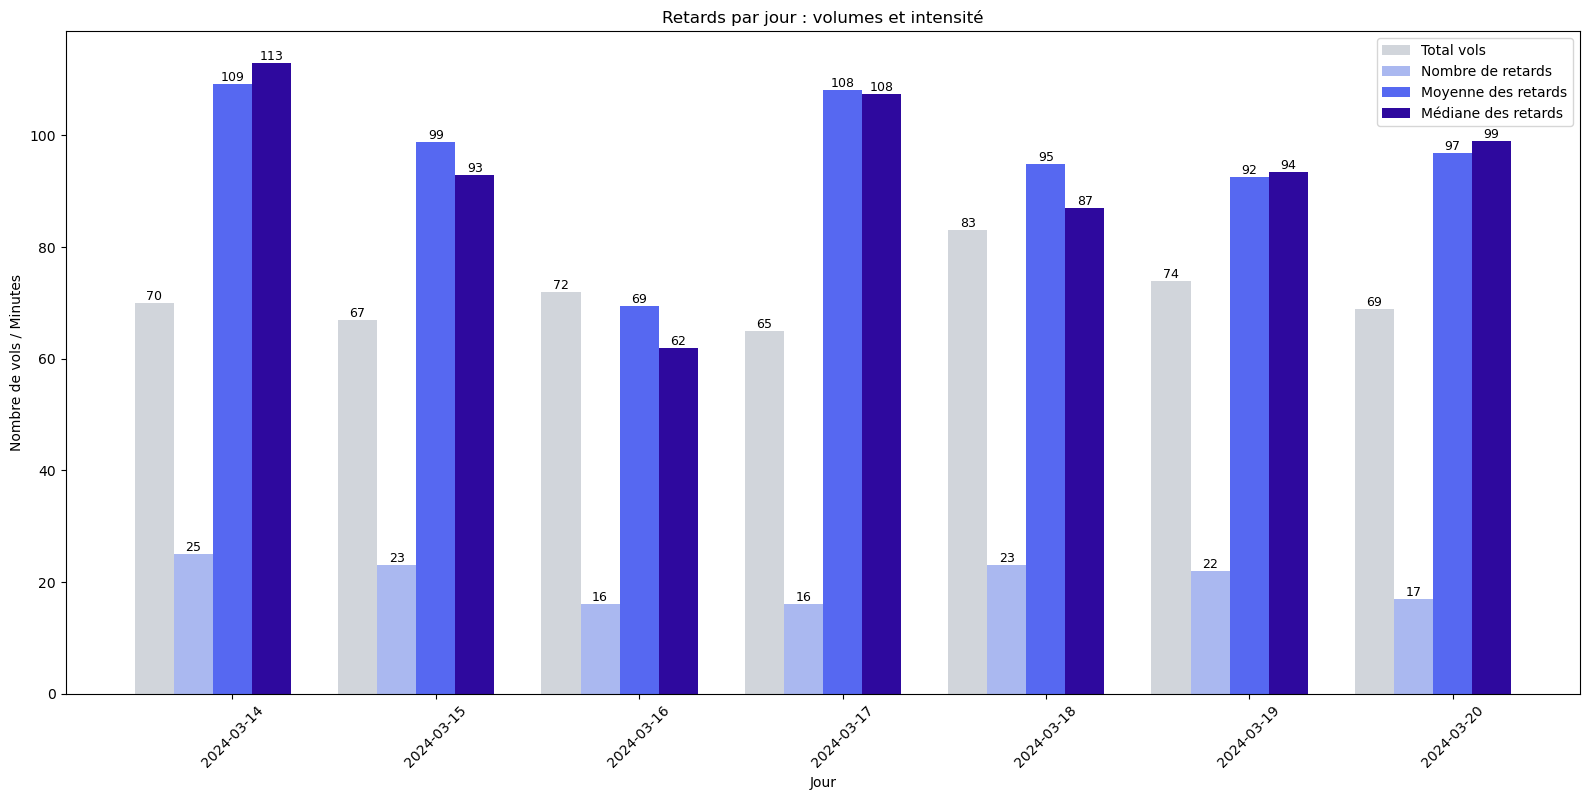

In [206]:
# ------------------------------------------------
# Volume de vols et intensité des retards par jour
# ------------------------------------------------

jours = tableau_retards["Date"].astype(str)
total_vols = tableau_retards["total_vols"]
nombre = tableau_retards["nombre_retards"]
moyenne = tableau_retards["moy_retards"]
mediane = tableau_retards["mediane_retards"]

# Position des barres (espacement entre les jours)
x = np.arange(len(jours)) * 1.3   # <-- séparation des jours
largeur = 0.25

plt.figure(figsize=(16,8.1))

bar0 = plt.bar(x - 2*largeur, total_vols, width=largeur,
               label="Total vols", color="#d1d5db")

bar1 = plt.bar(x - largeur, nombre, width=largeur,
               label="Nombre de retards", color="#aab8f0")

bar2 = plt.bar(x, moyenne, width=largeur,
               label="Moyenne des retards", color="#5668f1")

bar3 = plt.bar(x + largeur, mediane, width=largeur,
               label="Médiane des retards", color="#2e099e")

# Fonction d'ajout des labels
def add_labels(bars):
    for bar in bars:
        hauteur = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            hauteur,
            f"{hauteur:.0f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

# Labels sur les barres
add_labels(bar0)
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.xlabel("Jour")
plt.ylabel("Nombre de vols / Minutes")
plt.title("Retards par jour : volumes et intensité")
plt.xticks(x, jours, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Le nombre total de vols par jour varie de manière modérée : entre 65 et 83 vols. Il n’y a pas de pic extrême de trafic sur la période analysée.
Cependant, la proportion de vols retardés est élevée : en moyenne, près de 1 vol sur 3 est en retard sur certains jours.  
Cela suppose un problème opérationnel récurrent, pas un incident isolé.

Le retard moyen oscille entre 69 min et 109 min. Les 14, 15, 17 et 20 mars dépassent 95 minutes de retard moyen.

Le problème principal à CDG n’est pas le nombre de vols, mais l'importance et la récurrence des retards.

Les retards sont :
- fréquents
- longs
- stables dans le temps

#### **Analyse des retards par heure**

In [207]:
# ------------------------------------------
# Conversion des heures en heures décimales
# ------------------------------------------

df_flight_data_new["heure_depart"] = (df_flight_data_new["Actual_Departure"].dt.total_seconds() / 3600)

In [208]:
# -----------------------------
# Création des plages horaires
# -----------------------------

conditions = [
    (df_flight_data_new["heure_depart"] >= 5) & (df_flight_data_new["heure_depart"] < 9),
    (df_flight_data_new["heure_depart"] >= 9) & (df_flight_data_new["heure_depart"] < 16),
    (df_flight_data_new["heure_depart"] >= 16) & (df_flight_data_new["heure_depart"] < 21),
    (df_flight_data_new["heure_depart"] >= 21) | (df_flight_data_new["heure_depart"] < 5)
]

df_flight_data_new["Plage_Horaire"] = (df_flight_data_new["heure_depart"].apply(lambda h: plage_horaire(int(h)) if not np.isnan(h) else np.nan))

# ------------------------------------------------
# Copie de la plage horaire dans df_vols_retardes
# ------------------------------------------------

df_vols_retardes = df_vols_retardes.merge(df_flight_data_new[["Plage_Horaire"]], left_index=True, right_index=True,how="left")

# ---------------------------------------
# Nombre total de vols par plage horaire
# ---------------------------------------

total_vols_par_plage = (df_flight_data_new.groupby("Plage_Horaire").size().rename("total_vols"))

# -----------------------------------
# Nombre de vols retardés (≥ 15 min)
# -----------------------------------

retards_par_plage = (df_vols_retardes.groupby("Plage_Horaire").size().rename("vols_retardes"))

# ----------------------------------------
# Moyenne & médiane des retards (≥ 15 min)
# ----------------------------------------

stats_retards = (df_vols_retardes.groupby("Plage_Horaire").agg(
        retard_moyen=("Delay_Minutes", "mean"),
        retard_mediane=("Delay_Minutes", "median")
    ))

# -----------------------------
# Fusion dans un tableau final
# -----------------------------

tableau_final = (total_vols_par_plage.to_frame()
    .merge(retards_par_plage, on="Plage_Horaire", how="left")
    .merge(stats_retards, on="Plage_Horaire", how="left"))

# -------------------
# % de vols retardés
# -------------------

tableau_final["% vols retardés"] = (tableau_final["vols_retardes"] / tableau_final["total_vols"] * 100)

# Arrondis
tableau_final["retard_moyen"] = tableau_final["retard_moyen"].round(1)
tableau_final["% vols retardés"] = tableau_final["% vols retardés"].round(1)

# Remplacement NaN (plages sans retard)
tableau_final = tableau_final.fillna(0).reset_index()

# Ordre les colonnes
tableau_final = tableau_final[
    [
        "Plage_Horaire",
        "total_vols",
        "vols_retardes",
        "% vols retardés",
        "retard_moyen",
        "retard_mediane"
    ]]


print(tableau_final)


      Plage_Horaire  total_vols  vols_retardes  % vols retardés  retard_moyen  \
0  Journée (9h-16h)         139             43             30.9          97.4   
1     Matin (5h-9h)          96             30             31.2          89.0   
2     Nuit (21h-5h)         165             45             27.3          91.9   
3  Soirée (16h-21h)         100             24             24.0         113.0   

   retard_mediane  
0           103.0  
1            87.0  
2            87.0  
3           115.0  


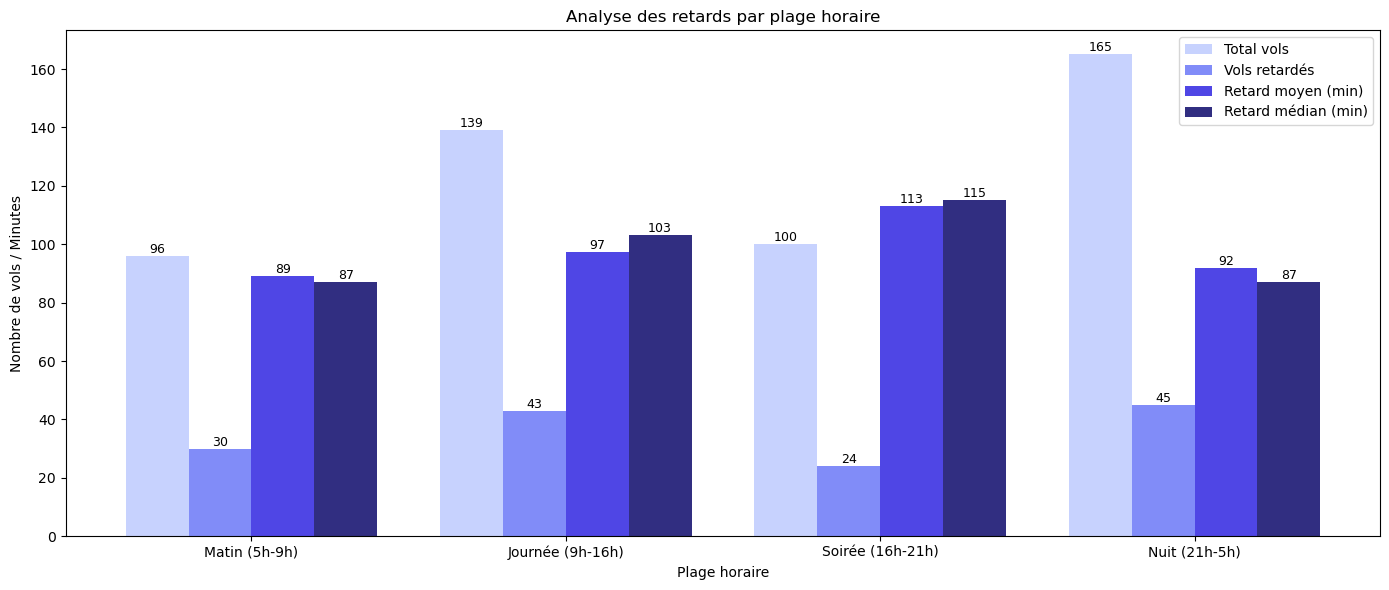

In [209]:
# -----------------------------
# Retards par plage horaire
# -----------------------------

# Ordre des plages horaires
ordre_plages = [
    "Matin (5h-9h)",
    "Journée (9h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-5h)"]

# Application de l'ordre
tableau_final["Plage_Horaire"] = pd.Categorical(tableau_final["Plage_Horaire"], categories=ordre_plages, ordered=True)

tableau_final = tableau_final.sort_values("Plage_Horaire")


# Données
plages = tableau_final["Plage_Horaire"]
total_vols = tableau_final["total_vols"]
vols_retardes = tableau_final["vols_retardes"]
retard_moyen = tableau_final["retard_moyen"]
retard_mediane = tableau_final["retard_mediane"]

# Position des barres
x = np.arange(len(plages))
largeur = 0.2

plt.figure(figsize=(14,6))

# Barres
bar1 = plt.bar(x - 1.5*largeur, total_vols, width=largeur,label="Total vols", color="#c7d2fe")
bar2 = plt.bar(x - 0.5*largeur, vols_retardes, width=largeur,label="Vols retardés", color="#818cf8")
bar3 = plt.bar(x + 0.5*largeur, retard_moyen, width=largeur,label="Retard moyen (min)", color="#4f46e5")
bar4 = plt.bar(x + 1.5*largeur, retard_mediane, width=largeur,label="Retard médian (min)", color="#312e81")

# Ajout des valeurs sur les barres
def add_labels(bars):
    for bar in bars:
        hauteur = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            hauteur,
            f"{hauteur:.0f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)

# Mise en forme
plt.xlabel("Plage horaire")
plt.ylabel("Nombre de vols / Minutes")
plt.title("Analyse des retards par plage horaire")
plt.xticks(x, plages)
plt.legend()
plt.tight_layout()
plt.show()


Le pourcentage de vols retardés est relativement stable, les écarts sont modérés (entre 24% et 31,2%).  
En revanche, l'importance des retards varie selon les moments de la journée.  
La soirée concentre les retards les plus longs, même si elle a le plus faible % de vols retardés, ce qui suggère un effet d’accumulation des perturbations et une pression accrue sur les ressources en fin de journée.

#### **Analyse des retards par causes**

In [210]:
# -----------------------------------
# Distribution des causes de retards
# -----------------------------------

retards_par_cause = (df_vols_retardes.groupby("Delay_Category")
    .agg(
        nb_vols=("Delay_Minutes", "count"),
        retard_moyen=("Delay_Minutes", "mean"),
        retard_total=("Delay_Minutes", "sum")
    )
    .round(1).sort_values("nb_vols", ascending=False))

retards_par_cause

,nb_vols,retard_moyen,retard_total
Delay_Category,,,
ATC,23,96.7,2225
Security,23,102.1,2348
Technical,21,116.8,2453
Weather,20,76.2,1524
Crew,19,94.2,1790
Ground_Handling,18,96.4,1735
Operational,18,90.6,1631


Les causes de retards sont réparties sur l’ensemble de la chaîne aéroportuaire, mêlant facteurs externes (ATC, météo), contraintes techniques et réglementaires (Technical, Crew) et dysfonctionnements opérationnels internes (Security, Ground Handling, Operational).

Aucune cause ne domine nettement en volume : les retards sont relativement homogènes.
- Security et ATC sont les plus fréquentes, tandis que Technical se distingue par les retards les plus longs et le retard total le plus élevé.
- Weather génère des retards plus courts, malgré un volume comparable.

Globalement, toutes les causes entraînent des retards longs et significatifs, indiquant des perturbations structurelles plutôt qu’un phénomène ponctuel.

#### **Analyse des retards par terminal**

In [211]:
# ---------------------------------
# Nombre total de vols par terminal
# ---------------------------------

total_vols_terminal = (df_flight_data_new.groupby("Terminal").size().reset_index(name="total_vols"))

# ---------------------------------------------
# Statistiques sur les vols retardés (≥ 15 min)
# ---------------------------------------------

tableau_retards_terminal = (df_vols_retardes.groupby("Terminal").agg(
        nombre_retards=("Delay_Minutes", "count"),
        moy_retards=("Delay_Minutes", "mean"),
        mediane_retards=("Delay_Minutes", "median")
    ).reset_index()
)

# Arrondi du retard moyen
tableau_retards_terminal["moy_retards"] = tableau_retards_terminal["moy_retards"].round(1)

# Fusion des deux tableaux
tableau_retards_terminal = tableau_retards_terminal.merge(total_vols_terminal,
    on="Terminal",
    how="left"
)

# Calcul du pourcentage de vols retardés
tableau_retards_terminal["% vols retardés"] = (tableau_retards_terminal["nombre_retards"] / tableau_retards_terminal["total_vols"]* 100).round(1)

# Réorganisation des colonnes
tableau_retards_terminal = tableau_retards_terminal[
    [
        "Terminal",
        "total_vols",
        "nombre_retards",
        "% vols retardés",
        "moy_retards",
        "mediane_retards"
    ]]


tableau_retards_terminal


,Terminal,total_vols,nombre_retards,% vols retardés,moy_retards,mediane_retards
0,1,53,13,24.5,91.2,82.0
1,2A,74,23,31.1,97.3,95.0
2,2B,72,26,36.1,97.1,102.0
3,2C,73,25,34.2,84.8,86.0
4,2D,68,13,19.1,88.9,96.0
5,2E,34,10,29.4,119.0,132.0
6,2F,69,14,20.3,104.4,89.5
7,3,57,18,31.6,101.7,110.0


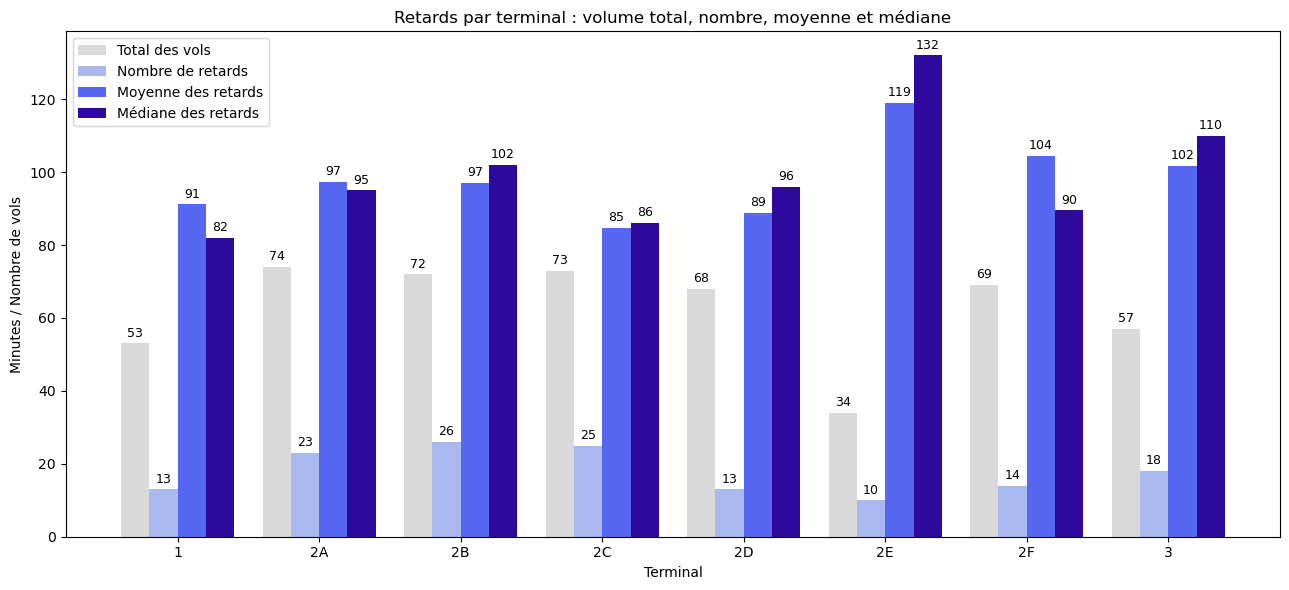

In [212]:
# Les données
terminal = tableau_retards_terminal["Terminal"]
total_vols = tableau_retards_terminal["total_vols"]
nombre = tableau_retards_terminal["nombre_retards"]
moyenne = tableau_retards_terminal["moy_retards"]
mediane = tableau_retards_terminal["mediane_retards"]

# Position des barres
x = np.arange(len(terminal))
largeur = 0.20   # largeur réduite pour 4 barres

plt.figure(figsize=(13,6))

# 4 barres côte à côte
bar0 = plt.bar(x - 1.5*largeur, total_vols, width=largeur, label="Total des vols", color="#d9d9d9")
bar1 = plt.bar(x - 0.5*largeur, nombre, width=largeur, label="Nombre de retards", color="#aab8f0")
bar2 = plt.bar(x + 0.5*largeur, moyenne, width=largeur, label="Moyenne des retards", color="#5668f1")
bar3 = plt.bar(x + 1.5*largeur, mediane, width=largeur, label="Médiane des retards", color="#2e099e")

# Ajouter les valeurs au-dessus des barres
def add_labels(bars):
    for bar in bars:
        hauteur = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            hauteur + 1,
            f'{hauteur:.0f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

add_labels(bar0)
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Labels et titre
plt.xlabel("Terminal")
plt.ylabel("Minutes / Nombre de vols")
plt.title("Retards par terminal : volume total, nombre, moyenne et médiane")
plt.xticks(x, terminal)
plt.legend()
plt.tight_layout()
plt.show()

Retards par terminal :

Indépendamment des différences entre terminaux, les retards observés sont globalement très importants en termes de durée.  
La durée moyenne des retards se situe entre 85 et 119 minutes, quel que soit le terminal considéré.

Cela signifie que lorsqu’un vol est retardé, le retard est rarement marginal : il dépasse largement le seuil des 15 minutes et atteint souvent plus d’une heure, voire près de deux heures dans certains terminaux.

Au-delà de ce constat global, l’analyse met en évidence des disparités entre les terminaux, tant en termes de volume d’activité que d'importance des retards.

- Le terminal 2E se distingue nettement : il présente les durées de retard les plus élevées, avec une moyenne de 119 minutes et une médiane de 132 minutes, alors même qu’il enregistre le volume total de vols le plus faible.
➜ Cela suggère des retards moins fréquents, mais particulièrement pénalisants lorsqu’ils surviennent.

- Les terminaux 2A, 2B et 2C concentrent :
    - un volume de vols élevé,
    - un nombre important de retards, mais avec des durées moyennes plus modérées.  
➜ Ils semblent un peu mieux absorber la charge opérationnelle malgré une activité dense.

- Le terminal 3 combine :
    - un volume d'activité intermédiaire,
    - des retards relativement fréquents,
    - des durées de retard élevées, ce qui en fait un point de vigilance opérationnelle.

Le terminal 1 apparaît comme le moins critique :
- nombre de vols modéré,
- peu de retards,
- durée moyenne des retards néanmoins élevée (environ 1h30), qui reste à surveiller.

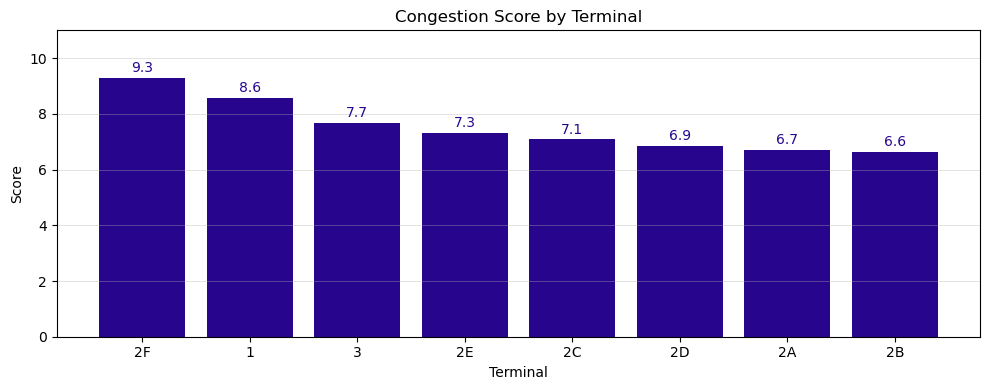

In [213]:
# ---------------------
# Retards par terminal
# ---------------------

# Données
df_flights = pd.read_csv("Raw_Flight_Data.csv")
df_passenger_flow = pd.read_csv("Passenger_Flow_Data.csv")

# Alignement Date / Date_Time
df_flights["Date"] = pd.to_datetime(df_flights["Date"]).dt.date
df_passenger_flow["Date"] = pd.to_datetime(df_passenger_flow["Date_Time"]).dt.date

# Blend (LEFT JOIN)
df = df_flights.merge(df_passenger_flow,
    how="left",
    on=["Terminal", "Date"])

# Agrégation
congestion = (df.groupby("Terminal", as_index=False)
    .agg({
        "Wait_Time_Minutes": "mean",
        "Queue_Length": "mean"
    }))

# Congestion Score
congestion["Congestion_Score"] = (
    congestion["Wait_Time_Minutes"] * congestion["Queue_Length"] / 100)

# 🔽 Tri du plus grand au plus petit
congestion = congestion.sort_values("Congestion_Score", ascending=False)

# Graphique
plt.figure(figsize=(10,4))

bars = plt.bar(
    congestion["Terminal"],
    congestion["Congestion_Score"],
    color="#27068d")  # bleu foncé

# Valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.1,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="#27068d")

plt.title("Congestion Score by Terminal")
plt.xlabel("Terminal")
plt.ylabel("Score")
plt.ylim(0, 11)
plt.grid(axis="y", linestyle="-", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

L’analyse du score de congestion met en évidence des différences notables entre les terminaux. Le terminal 2F présente le niveau de congestion le plus élevé, suivi du terminal 1, ce qui indique des difficultés importantes de fluidité dans ces zones. Les terminaux 3 et 2E affichent une congestion intermédiaire, tandis que 2B et 2A apparaissent comme les moins congestionnés.

Ces résultats suggèrent que les actions d’optimisation des flux et de gestion de capacité devraient être prioritairement concentrées sur 2F et 1, afin d’améliorer la fluidité globale et de limiter les risques de retards liés à la congestion.

La congestion n’explique pas à elle seule les retards.

- 2B et 2A : retards élevés malgré une faible congestion → problème d’organisation interne.
- 2F et 1 : forte congestion mais retards maîtrisés → gestion efficace des flux.
- 2C : cohérence entre congestion et retards.
- 2E : congestion modérée, retards rares mais très longs, indiquant des incidents ponctuels plutôt qu’un problème de congestion.
- 2D : faible congestion et faibles retards → terminal le plus stable.

#### **Cause des retards : impact de la météo sur les retards, annulations et opérations**

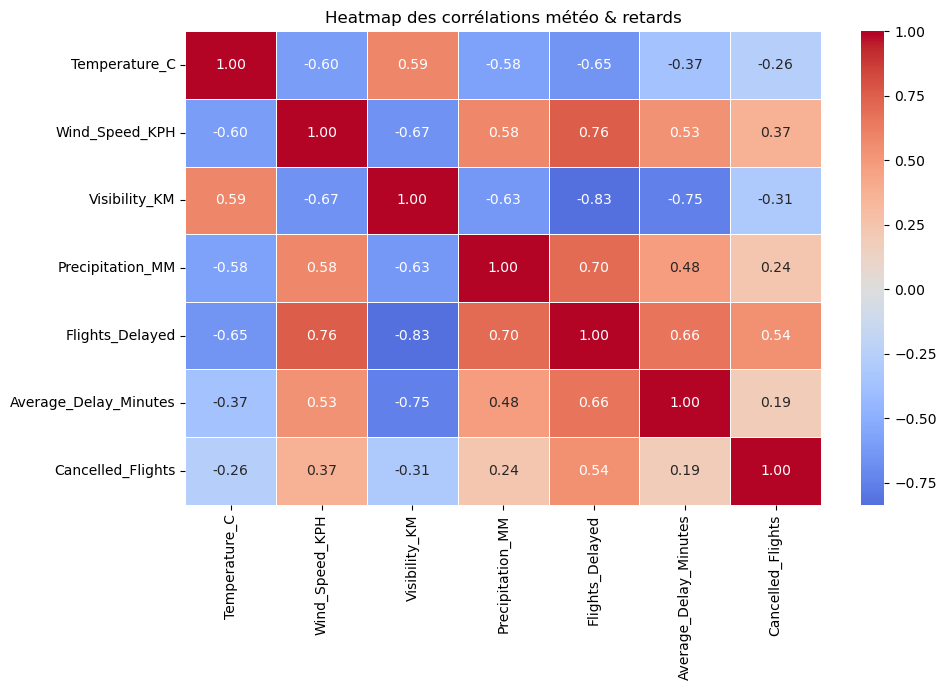

In [214]:
# ------------------------------------
# Heatmap corrélation météo et retards
# ------------------------------------

# Sélection des variables
variables = [
    "Temperature_C",
    "Wind_Speed_KPH",
    "Visibility_KM",
    "Precipitation_MM",
    "Flights_Delayed",
    "Average_Delay_Minutes",
    "Cancelled_Flights"
]


# Matrice de corrélation
corr_matrix = df_weather_new[variables].corr()

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Heatmap des corrélations météo & retards")
plt.tight_layout()
plt.show()

Les retards et perturbations aériennes sont fortement liés aux conditions météorologiques dégradées.

- La visibilité est le facteur le plus critique : plus elle diminue, plus le nombre de vols retardés augmente fortement (corrélation −0.82) et plus la durée moyenne des retards s’allonge (−0.74).
- Le vent et les précipitations ont un impact majeur :
    - Vent fort ↗ → plus de vols retardés (+0.76) et des retards plus longs (+0.53).
    - Précipitations ↗ → augmentation significative des retards (+0.71).
- La température joue un rôle indirect :
    - Les basses températures sont associées à davantage de retards (−0.65), probablement en lien avec le givre, la neige ou des conditions de piste dégradées.

Les annulations restent modérément corrélées aux conditions météo, mais augmentent surtout lorsque le nombre de vols retardés est élevé (+0.54).

**En résumé :** 
Les conditions de mauvaise visibilité, vent fort et fortes précipitations sont les principaux déclencheurs des retards, tandis que les annulations apparaissent comme une conséquence secondaire lorsque la situation se dégrade fortement.

In [215]:
# --------------------------------------------------------------
# Impact opérationnel de la météo sur les retards et annulations
# --------------------------------------------------------------

ordre_impact = ["None", "Minor", "Moderate", "Severe"]

# Transformation en catégorie ordonnée
df_weather_new["Operational_Impact"] = pd.Categorical(df_weather_new["Operational_Impact"], categories=ordre_impact, ordered=True)

# Agrégation des données
tableau_impact = (df_weather_new.groupby("Operational_Impact", observed=True).agg(
        vols_retardes=("Flights_Delayed", "mean"),
        retard_moyen=("Average_Delay_Minutes", "mean"),
        annulations=("Cancelled_Flights", "mean")
    ).round(1))



print("\n📊 Impact opérationnel sur les retards :")
tableau_impact


📊 Impact opérationnel sur les retards :


,vols_retardes,retard_moyen,annulations
Operational_Impact,,,
None,0.0,0.0,0.0
Minor,4.7,59.1,0.0
Moderate,19.9,67.4,0.0
Severe,36.4,83.0,3.1


L’analyse montre une relation directe entre la sévérité de l’impact opérationnel et la performance des vols.

- Aucun impact opérationnel → aucun retard ni annulation
- Impacts mineurs → premiers retards significatifs (≈ 1 h en moyenne)
- Impacts modérés → forte hausse du nombre de vols retardés (≈ 20 vols)
- Impacts sévères → situation critique : plus de 35 vols retardés en moyenne et retards les plus longs (≈ 83 minutes) avec apparition des annulations

Les situations modérées et sévères sont les principales sources de perturbation, avec un fort impact sur l’expérience passager et les opérations.

In [216]:
# -----------------------------------------------
# Retards et annulations selon l’état des pistes
# -----------------------------------------------

# Ordre conditions de piste
ordre_pistes = ["Dry", "Wet", "Contaminated", "Icy"]

# Transformation en catégorie ordonnée
df_weather_new["Runway_Condition"] = pd.Categorical(df_weather_new["Runway_Condition"], categories=ordre_pistes, ordered=True)

# Agrégation des données
tableau_runway = (df_weather_new.groupby("Runway_Condition", observed=True).agg(
        vols_retardes=("Flights_Delayed", "mean"),
        retard_moyen=("Average_Delay_Minutes", "mean"),
        annulations=("Cancelled_Flights", "mean")).round(1))



print("\n📊 Impact des conditions de piste sur les retards :\n")
tableau_runway



📊 Impact des conditions de piste sur les retards :



,vols_retardes,retard_moyen,annulations
Runway_Condition,,,
Dry,0.7,17.1,0.0
Wet,8.2,35.0,0.2
Contaminated,21.8,65.2,0.0
Icy,26.8,67.8,0.7


L’état des pistes joue un rôle déterminant dans les retards et les annulations.

- Piste sèche → Situation optimale : presque aucun retard et retards très courts (~17 min)
- Piste mouillée → Retards modérés, mais fréquents : ~35 min en moyenne
- Piste contaminée → Forte dégradation opérationnelle : plus de 20 vols retardés et retards longs (~65 min)
- Piste verglacée → Situation la plus critique : plus grand nombre de vols retardés, apparition d’annulations et retards élevés (~67 min)

In [217]:
# ------------------------------------------------------------
# Conversion de la colonne Heure (Timedelta → heure numérique)
# ------------------------------------------------------------

# Exemple : 0 days 23:00:00 → 23
df_weather_new["Heure_num"] = (df_weather_new["Heure"].dt.total_seconds() // 3600).astype(int)

# Définition des plages horaires
def plage_horaire(h):
    if 5 <= h < 9:
        return "Matin (05h-09h)"
    elif 9 <= h < 16:
        return "Journée (09h-16h)"
    elif 16 <= h < 21:
        return "Soirée (16h-21h)"
    else:
        return "Nuit (21h-05h)"


# Création de la colonne Plage_Horaire
df_weather_new["Plage_Horaire"] = df_weather_new["Heure_num"].apply(plage_horaire)

# Filtrage des retards réels (≥ 15 minutes)
df_retards_reels = df_weather_new[df_weather_new["Average_Delay_Minutes"] >= 15].copy()

# Agrégation par plage horaire
tableau_plages_horaires = (df_retards_reels.groupby("Plage_Horaire").agg(
        vols_retardes=("Flights_Delayed", "sum"),
        retard_moyen=("Average_Delay_Minutes", "mean"),
        annulations=("Cancelled_Flights", "sum"),
        arrets_sol=("Ground_Stops", "sum")
    ).reset_index())

# Arrondi du retard moyen
tableau_plages_horaires["retard_moyen"] = tableau_plages_horaires["retard_moyen"].round(1)

# Calcul du % de vols retardés
total_vols_retardes = tableau_plages_horaires["vols_retardes"].sum()

tableau_plages_horaires["% vols retardés"] = (tableau_plages_horaires["vols_retardes"] / total_vols_retardes * 100).round(1)

# Ordre des plages horaires
ordre_plages = [
    "Matin (05h-09h)",
    "Journée (09h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-05h)"
]

tableau_plages_horaires["Plage_Horaire"] = pd.Categorical(tableau_plages_horaires["Plage_Horaire"], categories=ordre_plages, ordered=True)

tableau_plages_horaires = tableau_plages_horaires.sort_values("Plage_Horaire")

# ==============================
# Réorganisation des colonnes
# ==============================
tableau_plages_horaires = tableau_plages_horaires[
    [
        "Plage_Horaire",
        "vols_retardes",
        "% vols retardés",
        "retard_moyen",
        "annulations",
        "arrets_sol"
    ]]


print("\n📊 Analyse par plage horaire (retards ≥ 15 min) :\n")
print(tableau_plages_horaires)



📊 Analyse par plage horaire (retards ≥ 15 min) :

       Plage_Horaire  vols_retardes  % vols retardés  retard_moyen  \
1    Matin (05h-09h)            239             15.1          81.4   
0  Journée (09h-16h)            374             23.6          73.4   
3   Soirée (16h-21h)            266             16.8          60.8   
2     Nuit (21h-05h)            708             44.6          59.6   

   annulations  arrets_sol  
1            8           2  
0           13           4  
3           13           0  
2           10           5  


- La nuit (21h–05h) concentre la plus forte proportion de vols retardés (44,6 %) et le plus grand nombre de retards (708), ce qui en fait la plage la plus critique en termes de volume.
- La journée (09h–16h) génère également beaucoup de retards (374 vols concernés soit 26,6% des vols retardés). Le retard assez élevé (73.4 minutes de retard en moyenne).
- Le matin (05h–09h) présente un retard moyen le plus élevé (81,4 min), indiquant des perturbations moins fréquentes mais plus sévères.
- La soirée (16h–21h) reste modérément impactée (16,8 % de vols retardés), mais la moyenne de retard est d'environ 1 heure, ce qui reste conséquent.

Les annulations sont surtout concentrées en journée et soirée, tandis que les arrêts au sol restent limités, quelle que soit la plage horaire.

**En résumé :**

- Nuit = risque très élevé en volume,
- Matin = retards les plus longs mais nombre de vols retardé le plus faible,
- Soirée = période modérément impactée mais durée de retard importante

### **Partie 2 : Analyse des ressources**

In [218]:
# ---------------------------------------
# Utilisation des ressources par terminal
# ---------------------------------------

# Ordre souhaité des terminaux
ordre_terminaux = [
    "1",
    "2A", "2B", "2C", "2D", "2E", "2F",
    "3"
]

# Conversion de la colonne Terminal en catégorie ordonnée
df_ressources_new["Terminal"] = pd.Categorical(df_ressources_new["Terminal"],categories=ordre_terminaux,ordered=True)

# Calcul du taux d’utilisation moyen par terminal
terminal_use_ressource = (df_ressources_new.groupby("Terminal", observed=True)["Utilization_Rate"].mean().round(1).reset_index().sort_values("Terminal"))

terminal_use_ressource


,Terminal,Utilization_Rate
0,1,69.7
1,2A,71.7
2,2B,71.2
3,2C,65.5
4,2D,75.3
5,2E,71.3
6,2F,66.9
7,3,68.6


L’analyse des taux d’utilisation moyens par terminal met en évidence une gestion globalement équilibrée des ressources à l’échelle de l’aéroport.
Les niveaux d’utilisation restent compris entre 65,5 % et 75,3 %, ce qui indique l’absence de saturation structurelle et une marge opérationnelle globale suffisante.

Le terminal T2D apparaît comme le plus sollicité, ce qui en fait un point de vigilance prioritaire en cas de pics de trafic ou de perturbations.
À l’inverse, T2C, T2F présentent des niveaux d’utilisation plus modérés, offrant des réserves de capacité potentielles.

In [219]:
# -------------------------------------------
# Taux d’utilisation moyen par plage horaire
# -------------------------------------------

plage_horaire_use_ressource = (df_ressources_new.groupby("Plage_Horaire", observed=False)["Utilization_Rate"].mean().round(1).reset_index())
plage_horaire_use_ressource

,Plage_Horaire,Utilization_Rate
0,Journée (9h-16h),69.3
1,Matin (5h-9h),69.7
2,Nuit (21h-5h),70.5
3,Soirée (16h-21h),70.3


Les taux d’utilisation des ressources sont très homogènes sur l’ensemble de la journée, avec des écarts faibles, compris entre 69,3 % et 70,5 % selon les plages horaires.

La nuit et la soirée présentent des taux légèrement plus élevés, mais l’écart reste marginal et ne traduit pas de saturation opérationnelle.

Aucune plage horaire ne se distingue par une surcharge ou une sous-utilisation marquée ; les marges de manœuvre existent sur l’ensemble de la journée.

In [220]:
# --------------------------------------------
# Utilisation des ressources par départements
# --------------------------------------------

capacite_use = (df_ressources_new.groupby("Department")
    .agg(
        capacite_moy=("Capacity", "mean"),
        utilisation_moy=("Utilization_Rate", "mean")
    ).round(1).reset_index())

capacite_use


,Department,capacite_moy,utilisation_moy
0,Air_Traffic,131.1,72.5
1,Customer_Service,135.8,69.4
2,Ground_Handling,144.8,70.1
3,Immigration,140.6,70.0
4,Maintenance,133.9,69.8
5,Security,124.6,67.3


L’analyse des capacités et des taux d’utilisation montre que les ressources de l’aéroport sont globalement bien dimensionnées, sans situation de surcharge critique à l’échelle des départements.

Les taux d’utilisation moyens se situent entre 67,3 % et 72,5 %, ce qui indique :

- une marge de manœuvre opérationnelle suffisante en conditions normales,
- l’absence de sous-effectif structurel chronique dans un département spécifique.

Le départements Air Traffic (72,5 %) présente le niveau d’utilisation le plus élevé.
Bien que cette valeur reste en-dessous des seuils de saturation, elles suggère que ce département est plus sensible aux pics de trafic et aux perturbations.

À l’inverse, Security, malgré des capacités moyennes plus faibles, affichent un taux d’utilisation modéré, ce qui indique une allocation globalement cohérente entre capacité et charge.

In [221]:
# ------------------------------------------
# Croisement départements et plages horaires
# ------------------------------------------

dept_plage_capacite_use = (df_ressources_new
    .groupby(["Department", "Plage_Horaire"], observed=False)
    .agg(
        capacite_moy=("Capacity", "mean"),
        utilisation_moy=("Utilization_Rate", "mean")
    ).round(1).reset_index())

dept_plage_capacite_use

,Department,Plage_Horaire,capacite_moy,utilisation_moy
0,Air_Traffic,Journée (9h-16h),113.8,73.2
1,Air_Traffic,Matin (5h-9h),160.9,70.5
2,Air_Traffic,Nuit (21h-5h),123.0,73.5
3,Air_Traffic,Soirée (16h-21h),148.1,71.6
4,Customer_Service,Journée (9h-16h),127.6,71.9
5,Customer_Service,Matin (5h-9h),174.1,69.0
6,Customer_Service,Nuit (21h-5h),118.6,67.0
7,Customer_Service,Soirée (16h-21h),143.4,69.8
8,Ground_Handling,Journée (9h-16h),133.8,66.7
9,Ground_Handling,Matin (5h-9h),147.0,70.0


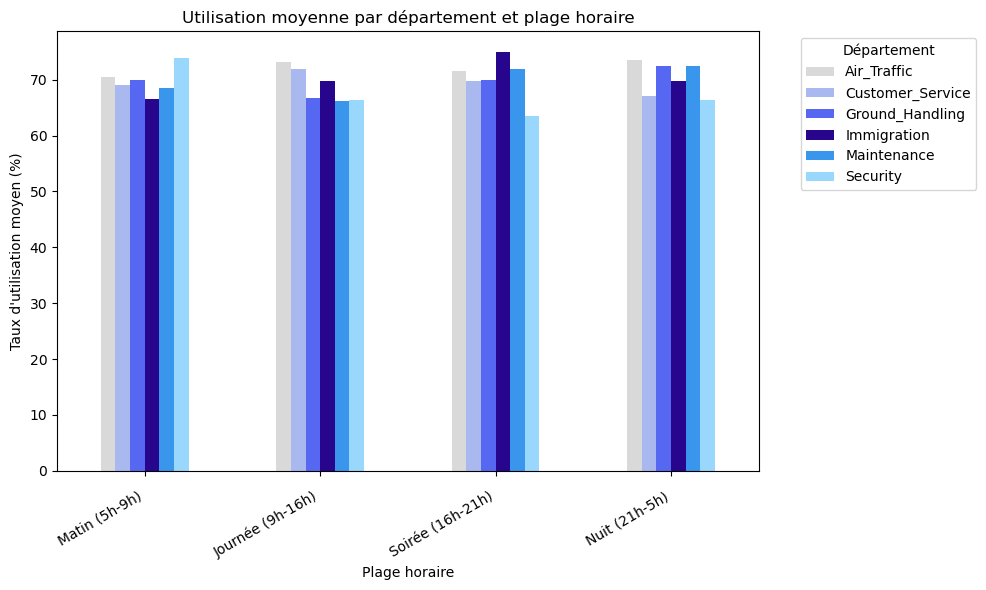

In [222]:
# ------------------------------------------------------------
# Utilisation des ressources par département et plage horaire
# ------------------------------------------------------------

# Agrégation des ressources par département et plage horaire
dept_plage_capacite_use = (df_ressources_new.groupby(["Department", "Plage_Horaire"])
    .agg(
        capacite_moy=("Capacity", "mean"),
        utilisation_moy=("Utilization_Rate", "mean")
    )
    .round(1).reset_index()
)

# Ordre des plages horaires
ordre_plages = [
    "Matin (5h-9h)",
    "Journée (9h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-5h)"
]

# Pivot
pivot_use = dept_plage_capacite_use.pivot(index="Plage_Horaire",columns="Department",values="utilisation_moy")

# Forçage de l’ordre
pivot_use = pivot_use.loc[ordre_plages]

# Palette de couleurs
blue_palette = [
    "#d9d9d9",
    "#aab8f0",
    "#5668f1",
    "#27068d",
    "#3996EC",
    "#9ad7fd"
]

# Graphique
pivot_use.plot(
    kind="bar",
    figsize=(10, 6),
    color=blue_palette
)

plt.xlabel("Plage horaire")
plt.ylabel("Taux d'utilisation moyen (%)")
plt.title("Utilisation moyenne par département et plage horaire")

plt.xticks(rotation=30, ha="right")
plt.tick_params(axis="x", pad=10)

plt.legend(title="Département", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Ce graphique révèle une utilisation relativement homogène des ressources aéroportuaires tout au long de la journée, avec des taux d'utilisation moyens oscillant entre 63,5% et 74,9% selon les départements et les plages horaires.

L’Immigration se distingue par des niveaux d’utilisation plus élevés, en particulier en soirée.
On observeune mobilisation continue des ressources sur l’ensemble de la journée.

Globalement, les ressources sont bien dimensionnées, sans surcharge critique visible, mais avec peu de marge sur certains départements clés.

In [223]:
# ------------------------------------------------------
# Répartition du staff par département et plage horaire
# ------------------------------------------------------

# Filtre sur les ressources de type "Staff"
df_staff = df_ressources_new[df_ressources_new["Resource_Type"] == "Staff"].copy()

# Décompte du nombre de staff par département et plage horaire
staff_dept_plage = (
    df_staff
    .groupby(["Department", "Plage_Horaire"])
    .agg(nb_staff=("Resource_ID", "count"))
    .reset_index()
)

# Pivot pour une lecture plus claire (tableau croisé)
staff_dept_plage_pivot = (
    staff_dept_plage
    .pivot(index="Department", columns="Plage_Horaire", values="nb_staff")
    .fillna(0)
    .astype(int)
)

print("📊 Répartition du staff par département et plage horaire :\n")
staff_dept_plage_pivot

📊 Répartition du staff par département et plage horaire :



Plage_Horaire,Journée (9h-16h),Matin (5h-9h),Nuit (21h-5h),Soirée (16h-21h)
Department,,,,
Air_Traffic,20,7,13,6
Customer_Service,10,5,17,14
Ground_Handling,10,6,14,9
Immigration,6,6,11,4
Maintenance,7,5,12,5
Security,11,7,11,7


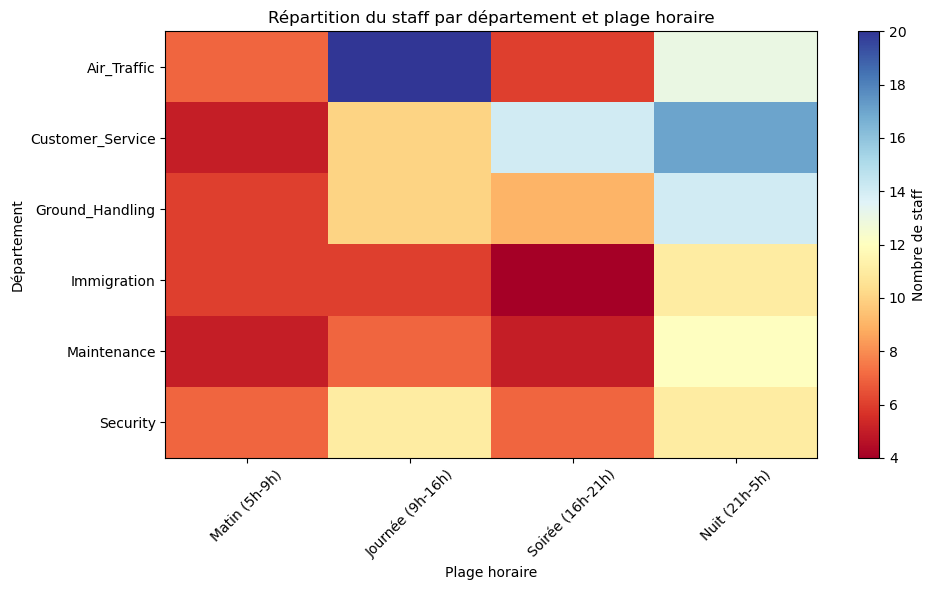

In [224]:
# ----------------------------------------------------------------
# Heatmap répartion du personnel par département et plage horaire
# ----------------------------------------------------------------

plt.figure(figsize=(10,6))

# Ordre des plages horaires
ordre_plages = [
    "Matin (5h-9h)",
    "Journée (9h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-5h)"
]

staff_dept_plage_pivot = staff_dept_plage_pivot.loc[:, ordre_plages]

# Heatmap avec palette Rouge (critique) → Bleu (confort)
plt.imshow(
    staff_dept_plage_pivot.values,
    aspect="auto",
    cmap="RdYlBu"   # Rouge = peu de staff | Bleu = beaucoup de staff
)

# Axes
plt.xticks(
    ticks=np.arange(len(staff_dept_plage_pivot.columns)),
    labels=staff_dept_plage_pivot.columns,
    rotation=45
)
plt.yticks(
    ticks=np.arange(len(staff_dept_plage_pivot.index)),
    labels=staff_dept_plage_pivot.index
)

# Barre de couleur
cbar = plt.colorbar()
cbar.set_label("Nombre de staff")

# Titres
plt.title("Répartition du staff par département et plage horaire")
plt.xlabel("Plage horaire")
plt.ylabel("Département")

plt.tight_layout()
plt.show()

La répartition du staff varie nettement selon les plages horaires et les départements.

- Le matin (5h–9h) est systématiquement la plage la moins dotée en staff, tous départements confondus.
- La journée (9h–16h) se distingue par un pic très marqué pour Air Traffic, qui atteint son niveau maximal d’effectifs.
- La soirée (16h–21h) est assez hétérogène, avec des niveaux particulièrement bas pour Immigration et Maintenance.
- La nuit (21h–5h) concentre globalement les effectifs les plus élevés dans la plupart des départements.

Dans l’ensemble, les données montrent une allocation du staff hétérogène selon les plages horaires, avec un creux matinal commun à tous les départements et une forte concentration des effectifs la nuit.

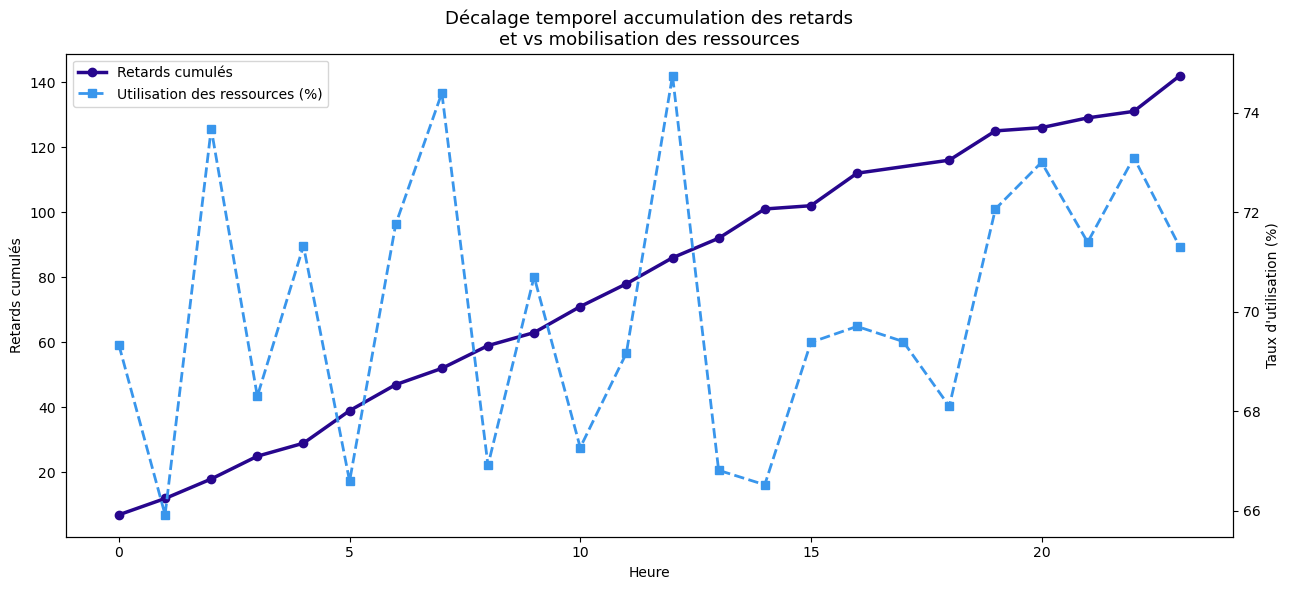

In [225]:
# ------------------------------
# Retards cumulés vs ressources
# ------------------------------

# Retards cumulés par heure
df_vols_retardes["heure"] = (df_vols_retardes["Actual_Departure"].dt.total_seconds() // 3600)

retards_h = (df_vols_retardes.groupby("heure").size().cumsum())

# Utilisation moyenne des ressources par heure
df_ressources_new["heure"] = (df_ressources_new["Shift_Start"].dt.total_seconds() // 3600)

ressources_h = (df_ressources_new.groupby("heure")["Utilization_Rate"].mean())

# Graphique
fig, ax1 = plt.subplots(figsize=(13,6))

# Courbe retards cumulés (axe gauche)
ax1.plot(
    retards_h.index,
    retards_h.values,
    color=blue_palette[3],
    linewidth=2.5,
    marker="o",
    label="Retards cumulés"
)

ax1.set_xlabel("Heure")
ax1.set_ylabel("Retards cumulés")

# Axe secondaire : utilisation ressources
ax2 = ax1.twinx()
ax2.plot(
    ressources_h.index,
    ressources_h.values,
    color=blue_palette[4],
    linewidth=2,
    linestyle="--",
    marker="s",
    label="Utilisation des ressources (%)"
)

ax2.set_ylabel("Taux d'utilisation (%)")

# Suppression des grilles
ax1.grid(False)
ax2.grid(False)

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper left")

# Titre
plt.title(
    "Décalage temporel accumulation des retards\net vs mobilisation des ressources",
    fontsize=13)

plt.tight_layout()
plt.show()


Le graphique met en évidence un décalage temporel marqué entre l’accumulation progressive des retards et la mobilisation des ressources.

Les retards cumulés augmentent de façon continue au fil des heures, tandis que le taux d’utilisation des ressources évolue de manière irrégulière.  
Les périodes où les retards cumulés sont les plus faibles correspondent aux niveaux d’utilisation des ressources les plus élevés, tandis qu’à mesure que les retards s’accumulent, la mobilisation des ressources tend à diminuer ou à progresser, mais pas suffisament.

In [226]:
# ------------------------------------------------
# IDENTIFICATION DES RESSOURCES UTILISEES (≥ 85 %)
# ------------------------------------------------
df_ressources_new["ressource_saturee"] = df_ressources_new["Utilization_Rate"] >= 85

tensions_brutes = (df_ressources_new[df_ressources_new["Utilization_Rate"] >= 85][
        [
            "Date",
            "Plage_Horaire",
            "Department",
            "Terminal",
            "Location",
            "Utilization_Rate",
            "Capacity"
        ]
    ]
    .sort_values(by=["Date", "Plage_Horaire", "Department", "Utilization_Rate"],ascending=[True, True, True, False]).reset_index(drop=True))

tensions_brutes.head()

,Date,Plage_Horaire,Department,Terminal,Location,Utilization_Rate,Capacity
0,2024-03-14,Journée (9h-16h),Air_Traffic,3,Terminal_3_Air_Traffic,97.0,34
1,2024-03-14,Journée (9h-16h),Air_Traffic,2C,Gate_2C_21,88.0,331
2,2024-03-14,Journée (9h-16h),Air_Traffic,NaN,Equipment_Bay_7,88.0,61
3,2024-03-14,Journée (9h-16h),Air_Traffic,1,Terminal_1_Air_Traffic,85.0,43
4,2024-03-14,Journée (9h-16h),Customer_Service,1,Terminal_1_Customer_Service,86.0,34


Terminal
1     18
3     18
2D     9
2B     7
2A     5
2C     4
2F     3
2E     2
dtype: int64


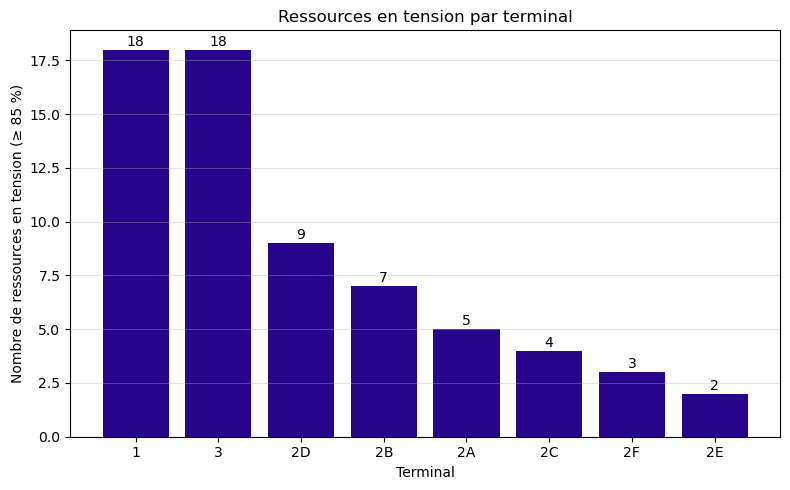

In [227]:
# -----------------------------------------------------
# RESSOURCES EN TENSION (≥ 85 %) — ANALYSE PAR TERMINAL
# -----------------------------------------------------

# Identification des ressources en tension
df_ressources_new["ressource_saturee"] = df_ressources_new["Utilization_Rate"] >= 85

tensions_brutes = (df_ressources_new[df_ressources_new["ressource_saturee"]][
        [
            "Date",
            "Plage_Horaire",
            "Department",
            "Terminal",
            "Location",
            "Utilization_Rate",
            "Capacity"
        ]]
    .sort_values(by=["Date", "Plage_Horaire", "Department", "Utilization_Rate"],ascending=[True, True, True, False])
    .reset_index(drop=True))

# Agrégation : nombre de ressources en tension par terminal
tensions_par_terminal = (tensions_brutes.groupby("Terminal", observed=True).size().sort_values(ascending=False))

print(tensions_par_terminal)

# Graphique : Ressources en tension par terminal
plt.figure(figsize=(8,5))

bars = plt.bar(
    tensions_par_terminal.index,
    tensions_par_terminal.values,
    color="#27068d")

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=10)

plt.xlabel("Terminal")
plt.ylabel("Nombre de ressources en tension (≥ 85 %)")
plt.title("Ressources en tension par terminal")
plt.grid(axis="y", linestyle="-", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

L’analyse met en évidence une forte hétérogénéité dans la répartition des tensions opérationnelles entre les terminaux, malgré des taux d’utilisation moyens globalement maîtrisés.

Deux terminaux se distinguent nettement :

- T1 et T3 concentrent le plus grand nombre de ressources en tension (18 chacune).
➜ Ce sont les principaux points de fragilité opérationnelle, où le risque de saturation et d’effet domino (retards, dégradation de service) est le plus élevé.  
- T2D constitue un second niveau de vigilance, avec 9 ressources en tension, confirmant son statut de terminal fortement sollicité.

À l’inverse :

- T2A, T2B et T2C présentent des tensions plus limitées, suggérant une meilleure absorption de la charge.
- T2E et T2F affichent très peu de situations critiques, indiquant une marge de capacité significative.

Le problème n’est pas un manque global de ressources, mais une concentration localisée des tensions sur certains terminaux.

In [228]:
# ---------------------------------
# DEPARTEMENTS EN TENSION (≥ 85 %)
# ---------------------------------

departements_tension = (df_ressources_new[df_ressources_new["Utilization_Rate"] >= 85]
    .groupby("Department")
    .agg(
        nb_ressources_en_tension=("Utilization_Rate", "count"),
        taux_utilisation_moyen=("Utilization_Rate", "mean"),
        taux_utilisation_max=("Utilization_Rate", "max")
    ).round(1).reset_index().sort_values("taux_utilisation_moyen", ascending=False))

departements_tension


,Department,nb_ressources_en_tension,taux_utilisation_moyen,taux_utilisation_max
4,Maintenance,22,91.8,96.0
0,Air_Traffic,45,91.4,97.0
1,Customer_Service,31,91.0,97.0
2,Ground_Handling,26,91.0,97.0
5,Security,22,90.8,97.0
3,Immigration,25,90.3,96.0


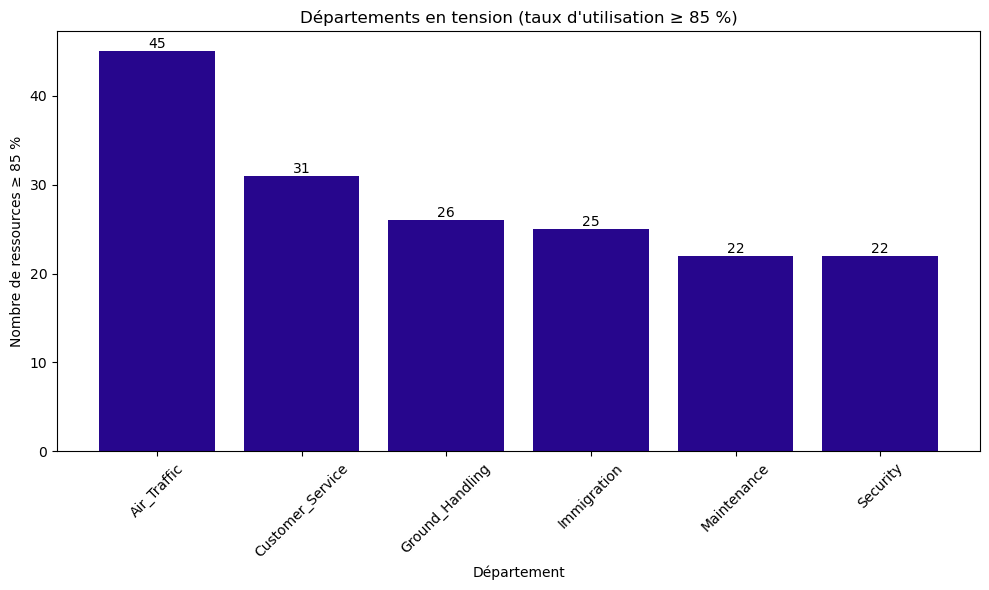

In [229]:
# ------------------------
# Départements en tension
# ------------------------

departements_tension = (df_ressources_new[df_ressources_new["Utilization_Rate"] >= 85].groupby("Department").agg(
        nb_ressources_en_tension=("Utilization_Rate", "count"),
        taux_utilisation_moyen=("Utilization_Rate", "mean")
    ).round(1).reset_index().sort_values("nb_ressources_en_tension", ascending=False))

plt.figure(figsize=(10,6))

bars = plt.bar(
    departements_tension["Department"],
    departements_tension["nb_ressources_en_tension"],
    color="#27068d"
)

plt.xlabel("Département")
plt.ylabel("Nombre de ressources ≥ 85 %")
plt.title("Départements en tension (taux d'utilisation ≥ 85 %)")

# Ajout des valeurs sur chaque barre
for bar in bars:
    hauteur = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        hauteur,
        int(hauteur),
        ha="center",
        va="bottom"
    )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Le graphique met en évidence que Air Traffic est de loin le département le plus fréquemment en situation de tension, suivi par Customer Service et Ground Handling.  
Ces départements concentrent l’essentiel des ressources dont le taux d’utilisation dépasse 85 %, ce qui en fait des points de vigilance opérationnelle prioritaires.

Cependant, la lecture du tableau des ressources par département par plage horaire permet de nuancer ce constat :
les taux d’utilisation moyens restent globalement inférieurs à 75 %, y compris pour les départements les plus exposés. Cela indique que les situations de tension observées sont ponctuelles, liées à des pics d’activité ou à des perturbations, plutôt qu’à un sous-dimensionnement structurel permanent.

In [230]:
# --------------------------
# Retards par plage horaire
# --------------------------

retards_horaire = (tableau_final.groupby("Plage_Horaire", observed=False)
    .agg(
        vols_retardes=("vols_retardes", "sum"),
        retard_moyen=("retard_moyen", "mean")
    ).reset_index())

# ---------------------------------------------
# Utilisation des ressources par plage horaire
# ---------------------------------------------

ressources_horaire = (df_ressources_new.groupby("Plage_Horaire")
    .agg(utilisation_moy=("Utilization_Rate", "mean"))
    .round(1).reset_index())

# -------------------------
# Fusion des deux tableaux
# -------------------------

croisement_retards_ressources = (retards_horaire
    .merge(
        ressources_horaire,
        on="Plage_Horaire",
        how="left"
    ))

# --------------------------
# Ordre des plages horaires
# --------------------------

ordre_plages = [
    "Matin (5h-9h)",
    "Journée (9h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-5h)"
]

croisement_retards_ressources["Plage_Horaire"] = pd.Categorical(croisement_retards_ressources["Plage_Horaire"],categories=ordre_plages,ordered=True)

croisement_retards_ressources = croisement_retards_ressources.sort_values("Plage_Horaire")

# Affichage final
croisement_retards_ressources

,Plage_Horaire,vols_retardes,retard_moyen,utilisation_moy
0,Matin (5h-9h),30,89.0,69.7
1,Journée (9h-16h),43,97.4,69.3
2,Soirée (16h-21h),24,113.0,70.3
3,Nuit (21h-5h),45,91.9,70.5


Les retards à CDG ne sont pas principalement causés par un manque global de ressources, mais par un décalage temporel entre les pics de perturbations et la mobilisation effective des moyens, particulièrement en soirée et de nuit.

L’analyse croisée des retards et de l’utilisation des ressources par plage horaire met en évidence un désalignement structurel entre la survenue des perturbations et la mobilisation des moyens opérationnels.

- La soirée (16h–21h) concentre les retards les plus longs (113 minutes en moyenne), alors que le taux d’utilisation des ressources reste modéré (≈70 %).
➜ Cela suggère un effet d’accumulation des perturbations non absorbé par les dispositifs en place en fin de journée.

- La nuit (21h–5h) présente le plus grand nombre de vols retardés, sans augmentation correspondante de l’utilisation des ressources.
➜ Les moyens disponibles semblent insuffisamment mobilisés au regard du volume de perturbations.

- La journée (9h–16h) combine un fort volume de retards et une utilisation des ressources comparable aux autres plages.
➜ Les ressources sont mobilisées, mais sans surcapacité, ce qui limite la résilience en cas d’aléas.

- Le matin (5h–9h) affiche des retards importants mais moins fréquents, probablement liés à des retards hérités de la veille, plus qu’à un manque immédiat de ressources.

In [231]:
# -----------------------------------------------
# Nombre de staff vs retards (par plage horaire)
# -----------------------------------------------

# Filtrage sur les ressources de type "Staff"
df_staff = df_ressources_new[df_ressources_new["Resource_Type"] == "Staff"].copy()

# Décompte du nombre de staff par plage horaire
staff_par_plage = (df_staff.groupby("Plage_Horaire")
    .agg(nb_staff=("Resource_ID", "count")).reset_index())

# Calcul des retards par plage horaire (vols ≥ 15 min)
retards_par_plage = (df_vols_retardes.groupby("Plage_Horaire")
    .agg(
        vols_retardes=("Delay_Minutes", "count"),
        retard_moyen=("Delay_Minutes", "mean")
    ).reset_index())

# Croisement staff et retards
croisement_staff_retards = (retards_par_plage.merge(staff_par_plage, on="Plage_Horaire", how="left"))

# Arrondi retard moyen
croisement_staff_retards["retard_moyen"] = croisement_staff_retards["retard_moyen"].round(1)

# Affichage
croisement_staff_retards

,Plage_Horaire,vols_retardes,retard_moyen,nb_staff
0,Journée (9h-16h),43,97.4,64
1,Matin (5h-9h),30,89.0,36
2,Nuit (21h-5h),45,91.9,78
3,Soirée (16h-21h),24,113.0,45


Le volume de staff n’explique pas directement les retards.

Les données montrent que les plages horaires disposant du plus grand nombre de staff (nuit : 78, journée : 64) sont aussi celles où le nombre de vols retardés est le plus élevé (45 et 43).  
À l’inverse, le matin, avec l’effectif le plus faible (36), présente à la fois le plus faible nombre de vols retardés et le retard moyen le plus bas.

Le retard moyen le plus élevé est observé en soirée (113 min), alors que l’effectif y est intermédiaire (45).

Sur la période analysée, aucune relation directe et proportionnelle n’apparaît entre le nombre de staff et l’intensité des retards.

In [232]:
# ------------------------------------------------------------------
# Répartition des Equipment_Status par Département et Plage Horaire
# ------------------------------------------------------------------

equipement_dep_plage = (df_ressources_new.groupby(["Department", "Plage_Horaire", "Equipment_Status"]).size().reset_index(name="nb_equipements"))

# Pivot pour une lecture claire
pivot_equipement_dep_plage = (equipement_dep_plage
    .pivot_table(
        index=["Department", "Plage_Horaire"],
        columns="Equipment_Status",
        values="nb_equipements",
        fill_value=0
    ).reset_index())


pivot_equipement_dep_plage

Equipment_Status,Department,Plage_Horaire,Available,Breakdown,Maintenance,Reserved
0,Air_Traffic,Journée (9h-16h),37.0,4.0,4.0,3.0
1,Air_Traffic,Matin (5h-9h),23.0,0.0,2.0,3.0
2,Air_Traffic,Nuit (21h-5h),40.0,4.0,3.0,5.0
3,Air_Traffic,Soirée (16h-21h),22.0,0.0,1.0,2.0
4,Customer_Service,Journée (9h-16h),35.0,3.0,1.0,3.0
5,Customer_Service,Matin (5h-9h),18.0,3.0,1.0,1.0
6,Customer_Service,Nuit (21h-5h),40.0,3.0,1.0,3.0
7,Customer_Service,Soirée (16h-21h),32.0,1.0,3.0,0.0
8,Ground_Handling,Journée (9h-16h),24.0,2.0,1.0,4.0
9,Ground_Handling,Matin (5h-9h),17.0,1.0,4.0,0.0


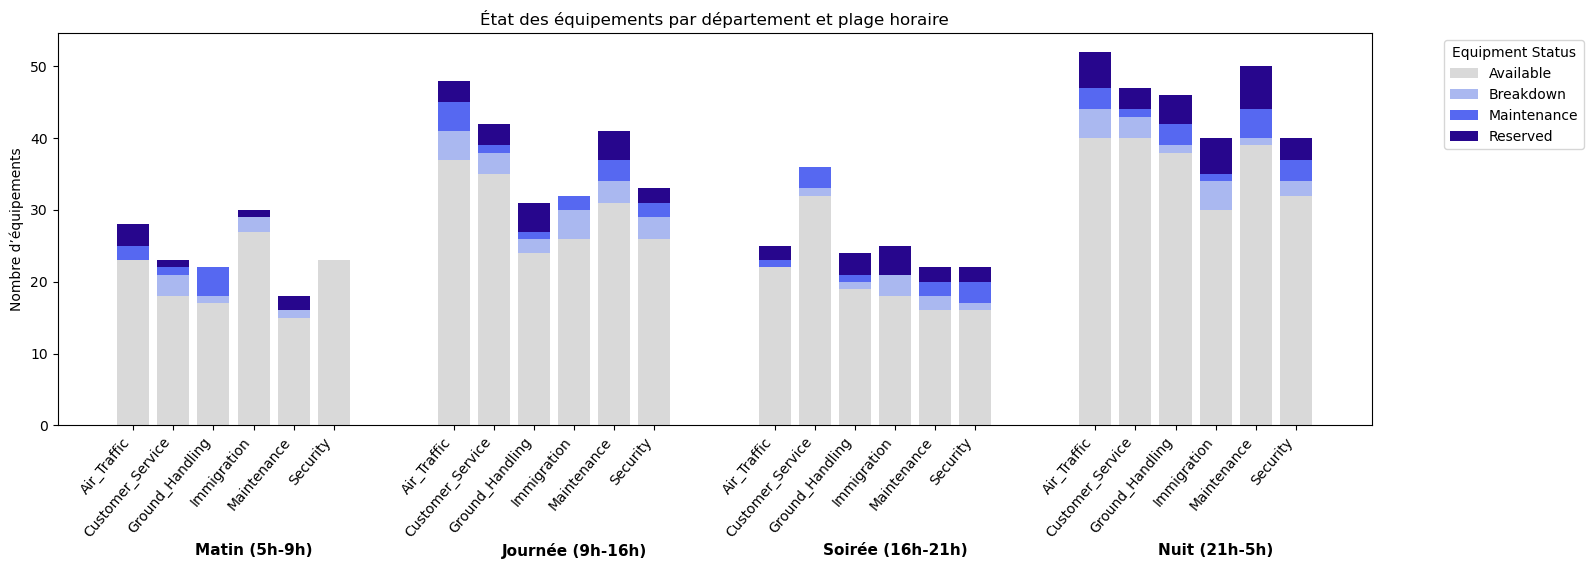

In [233]:
# ------------------------------------------------------
# État des équipements par département et plage horaire
# ------------------------------------------------------

# Palette de couleurs
blue_palette = [
    "#d9d9d9",
    "#aab8f0",
    "#5668f1",
    "#27068d",
    "#3996EC",
    "#9ad7fd"
]

# Préparation des données
equipement_status = (df_ressources_new.groupby(["Plage_Horaire", "Department", "Equipment_Status"]).size().reset_index(name="nb"))

pivot_status = equipement_status.pivot_table(
    index=["Plage_Horaire", "Department"],
    columns="Equipment_Status",
    values="nb",
    fill_value=0)

ordre_plages = [
    "Matin (5h-9h)",
    "Journée (9h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-5h)"
]

departements = pivot_status.index.levels[1]
nb_dep = len(departements)
gap = 2  #espace entre les plages horaire

# Création des positions X avec espaces
positions = []
labels = []
current_pos = 0
plage_centers = []

for plage in ordre_plages:
    for dep in departements:
        positions.append(current_pos)
        labels.append(dep)
        current_pos += 1
    plage_centers.append(current_pos - nb_dep / 2)
    current_pos += gap

# Graphique
fig, ax = plt.subplots(figsize=(16, 6))
bottom = [0] * len(positions)

for status, color in zip(pivot_status.columns, blue_palette):
    values = []
    for plage in ordre_plages:
        for dep in departements:
            values.append(pivot_status.loc[(plage, dep), status])
    ax.bar(positions, values, bottom=bottom, label=status, color=color)
    bottom = [b + v for b, v in zip(bottom, values)]

# Labels départements
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=50, ha="right")

# Labels plages horaires
for center, plage in zip(plage_centers, ordre_plages):
    ax.text(
        center,
        -0.30,
        plage,
        ha="center",
        va="top",
        transform=ax.get_xaxis_transform(),
        fontsize=11,
        fontweight="bold"
    )

ax.set_ylabel("Nombre d’équipements")
ax.set_title("État des équipements par département et plage horaire")
ax.legend(title="Equipment Status", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


La majorité des équipements sont en statut Available, quel que soit le département et la plage horaire.

Les statuts Breakdown, Maintenance et Reserved restent minoritaires mais présents dans tous les départements, sans concentration sur une plage horaire unique.

La nuit (21h–5h) affiche systématiquement des volumes plus élevés d’équipements (tous statuts confondus), cohérents avec les volumes globaux observés sur cette plage.

Aucun département ne présente une plage horaire avec une absence totale d’équipements disponibles, ce qui indique une couverture opérationnelle continue.

### **Partie 3 : Analyse des flux de passagers**

In [234]:
# -------------------------------
# ANALYSE DU VOLUME DE PASSAGERS
# -------------------------------

# Création de la plage horaire À PARTIR DE LA FONCTION EXISTANTE
df_passenger_new["Heure_num"] = (df_passenger_new["Heure"].dt.total_seconds() // 3600).astype(int)

df_passenger_new["Plage_Horaire"] = df_passenger_new["Heure_num"].apply(plage_horaire)

# Volume de passagers par terminal
volume_passagers_terminal = (df_passenger_new.groupby("Terminal").agg(
        volume_flux=("Record_ID", "count"),
        file_moyenne=("Queue_Length", "mean"),
        debit_moyen=("Throughput_Rate", "mean")
    ).round(1).reset_index())

print("\n📊 Volume de flux passagers par terminal :\n")
print(volume_passagers_terminal)



📊 Volume de flux passagers par terminal :

  Terminal  volume_flux  file_moyenne  debit_moyen
0        1          331          40.7        109.3
1       2A          263          37.1        107.3
2       2B          310          36.8        111.4
3       2C          275          37.4        113.9
4       2D          290          36.4        107.1
5       2E          303          37.4        108.6
6       2F          254          44.1        107.4
7        3          261          38.9        110.0


Le volume de flux passagers est relativement homogène entre les terminaux, avec des valeurs comprises entre 254 et 331 passagers. Aucun terminal ne présente de volume extrême, même si le terminal 1 enregistre le flux le plus élevé.

Les files moyennes varient davantage selon les terminaux : elles sont particulièrement élevées au terminal 2F (44,1) et au terminal 1 (40,7), tandis que les niveaux les plus faibles sont observés aux terminaux 2D (36,4) et 2B (36,8).

Le débit moyen reste très stable, compris entre 107,1 et 113,9, avec un maximum au terminal 2C.
Ces écarts montrent que les différences d’expérience passager tiennent davantage à la gestion locale qu’au volume de trafic.

In [235]:
# --------------------------------------
# Volume de passagers par plage horaire
# --------------------------------------

volume_passagers_plage = (df_passenger_new.groupby("Plage_Horaire", observed=False)
    .agg(
        volume_flux=("Record_ID", "count"),
        file_moyenne=("Queue_Length", "mean"),
        debit_moyen=("Throughput_Rate", "mean")
    ).round(1).reset_index())

# Ordre des plages horaires
ordre_plages = [
    "Matin (05h-09h)",
    "Journée (09h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-05h)"]

volume_passagers_plage["Plage_Horaire"] = pd.Categorical(volume_passagers_plage["Plage_Horaire"],categories=ordre_plages,ordered=True)

volume_passagers_plage = volume_passagers_plage.sort_values("Plage_Horaire")

print("\n📊 Volume de flux passagers par plage horaire :\n")
print(volume_passagers_plage)


📊 Volume de flux passagers par plage horaire :

       Plage_Horaire  volume_flux  file_moyenne  debit_moyen
1    Matin (05h-09h)          378          70.0        109.4
0  Journée (09h-16h)          656          19.4        112.3
3   Soirée (16h-21h)          469          71.1        112.1
2     Nuit (21h-05h)          784          19.9        105.3


Les données montrent clairement que le volume de passagers n’explique pas à lui seul la congestion.

La nuit et la journée concentrent les volumes de passagers les plus élevés (784 et 656), tout en affichant des files moyennes très faibles (≈ 19–20).

À l’inverse, le matin et la soirée présentent des files très élevées (≈ 70), alors que les volumes de passagers y sont plus modérés (378 et 469).

Conclusion : La formation des files est directement liée au niveau d’effectifs du personnel par plage horaire, bien plus qu’au volume de passagers.
- Plages avec effectifs élevés → files faibles, même en cas de fort volume (nuit, journée) 
- Plages avec effectifs faibles → files élevées, même avec un volume plus bas (matin, soirée)

In [236]:
# -----------------------------------------------------
# Volume croisé : terminal × plage horaire
# -----------------------------------------------------
volume_passagers_terminal_plage = (df_passenger_new.groupby(["Plage_Horaire", "Terminal"])
    .agg(
        volume_flux=("Record_ID", "count"))
    .reset_index())

print("\n📊 Volume de flux passagers par terminal et plage horaire :\n")
print(volume_passagers_terminal_plage)


📊 Volume de flux passagers par terminal et plage horaire :

        Plage_Horaire Terminal  volume_flux
0   Journée (09h-16h)        1           76
1   Journée (09h-16h)       2A           82
2   Journée (09h-16h)       2B           85
3   Journée (09h-16h)       2C           83
4   Journée (09h-16h)       2D           82
5   Journée (09h-16h)       2E           84
6   Journée (09h-16h)       2F           71
7   Journée (09h-16h)        3           93
8     Matin (05h-09h)        1           65
9     Matin (05h-09h)       2A           32
10    Matin (05h-09h)       2B           46
11    Matin (05h-09h)       2C           43
12    Matin (05h-09h)       2D           46
13    Matin (05h-09h)       2E           55
14    Matin (05h-09h)       2F           45
15    Matin (05h-09h)        3           46
16     Nuit (21h-05h)        1          123
17     Nuit (21h-05h)       2A           86
18     Nuit (21h-05h)       2B          122
19     Nuit (21h-05h)       2C           99
20     Nuit (21

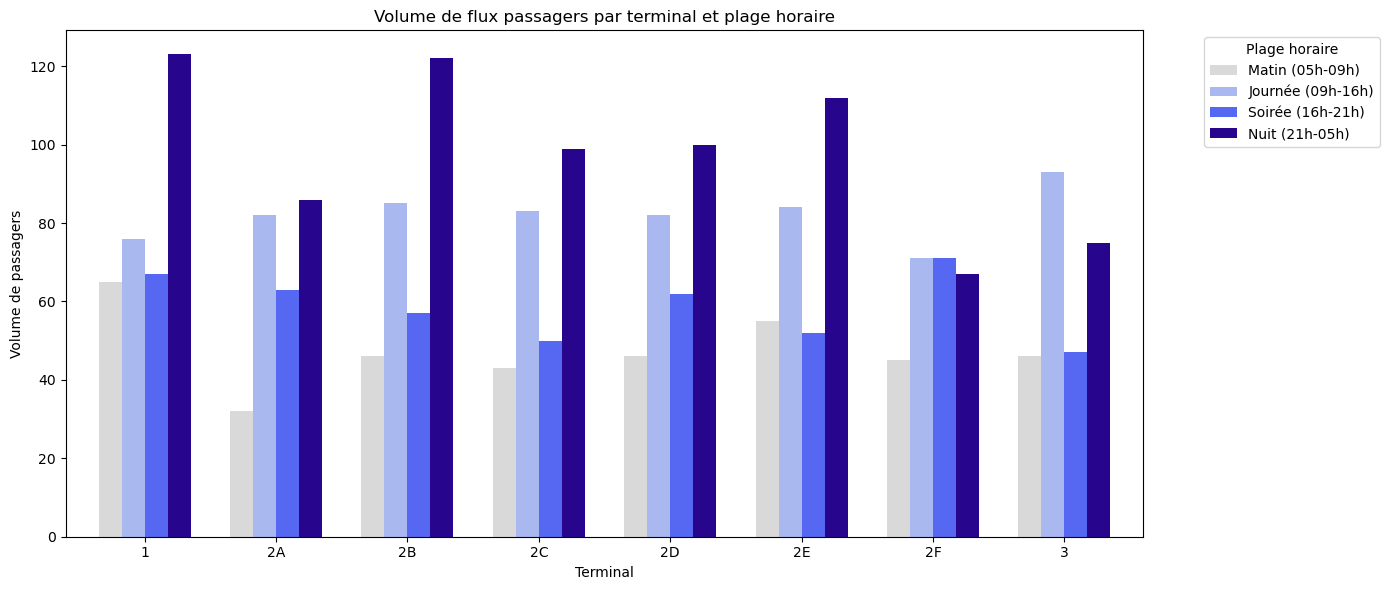

In [237]:
# --------------------------------------------------------
# Volume de flux passagers par terminal et plages horaires
# --------------------------------------------------------

# Agrégation
volume_passagers_terminal_plage = (df_passenger_new.groupby(["Plage_Horaire", "Terminal"])
    .agg(volume_flux=("Record_ID", "count"))
    .reset_index()
)

# Pivot : Terminaux en index, Plages horaires en colonnes
pivot_volume = volume_passagers_terminal_plage.pivot(
    index="Terminal",
    columns="Plage_Horaire",
    values="volume_flux"
).fillna(0)

# Ordre des plages horaires
ordre_plages = [
    "Matin (05h-09h)",
    "Journée (09h-16h)",
    "Soirée (16h-21h)",
    "Nuit (21h-05h)"]

pivot_volume = pivot_volume[ordre_plages]

# Graphique
pivot_volume.plot(
    kind="bar",
    figsize=(14, 6),
    width=0.7,
    color=blue_palette
)

plt.xlabel("Terminal")
plt.ylabel("Volume de passagers")
plt.title("Volume de flux passagers par terminal et plage horaire")
plt.xticks(rotation=0)
plt.legend(title="Plage horaire", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Le volume de passagers dépend principalement de la plage horaire et non du terminal.

- La nuit (21h–05h) concentre les flux les plus élevés sur tous les terminaux.
- La journée (09h–16h) arrive en second avec des volumes élevés et homogènes.
- La soirée est intermédiaire, le matin reste la période la moins chargée.

Les pics de trafic sont temporels, pas structurellement liés à un terminal spécifique.


📊 Congestion par process passager :

        Process_Type  file_moyenne  attente_moyenne  duree_traitement  \
1            Customs          40.6             20.4             104.5   
0      Baggage_Claim          39.3             19.4             104.5   
2     Immigration_EU          37.3             19.1             205.5   
4           Security          38.8             19.0              72.1   
3  Immigration_NonEU          36.9             18.9             218.8   

   volume_flux  
1          471  
0          445  
2          474  
4          420  
3          477  


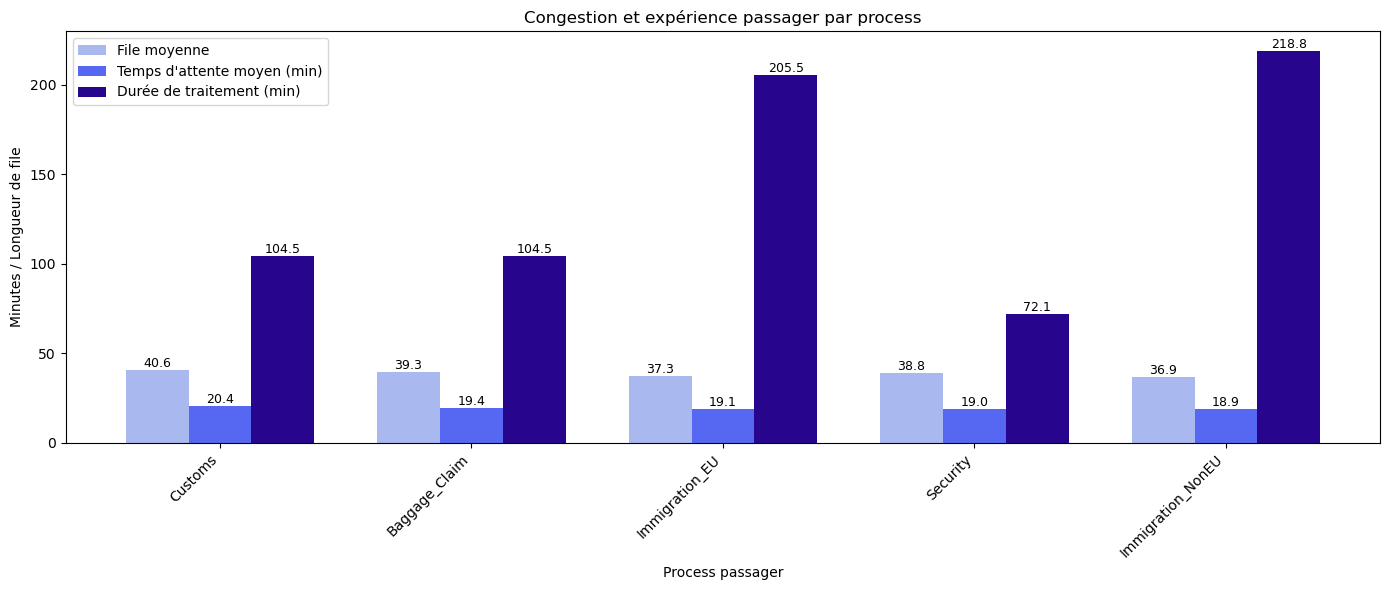

In [238]:
# -----------------------
# Agrégation par process
# -----------------------

congestion_process = (df_passenger_new.groupby("Process_Type")
    .agg(
        file_moyenne=("Queue_Length", "mean"),
        attente_moyenne=("Wait_Time_Minutes", "mean"),
        duree_traitement=("Processing_Duration", "mean"),
        volume_flux=("Record_ID", "count")
    ).round(1).reset_index().sort_values("attente_moyenne", ascending=False))

print("\n📊 Congestion par process passager :\n")
print(congestion_process)

# ----------
# Graphique
# ----------

x = np.arange(len(congestion_process))
largeur = 0.25

plt.figure(figsize=(14,6))

bar1 = plt.bar(
    x - largeur,
    congestion_process["file_moyenne"],
    width=largeur,
    label="File moyenne",
    color=blue_palette[1])

bar2 = plt.bar(
    x,
    congestion_process["attente_moyenne"],
    width=largeur,
    label="Temps d'attente moyen (min)",
    color=blue_palette[2])

bar3 = plt.bar(
    x + largeur,
    congestion_process["duree_traitement"],
    width=largeur,
    label="Durée de traitement (min)",
    color=blue_palette[3])

# Ajout des valeurs sur les barres
def add_labels(bars):
    for bar in bars:
        hauteur = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            hauteur,
            f"{hauteur:.1f}",
            ha="center",
            va="bottom",
            fontsize=9)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.xticks(x, congestion_process["Process_Type"], rotation=45, ha="right")
plt.xlabel("Process passager")
plt.ylabel("Minutes / Longueur de file")
plt.title("Congestion et expérience passager par process")
plt.legend()
plt.tight_layout()
plt.show()

Les files moyennes et les temps d’attente sont très proches entre les différents process, avec des valeurs comprises entre 36,9 et 40,6 pour les files et autour de 19 à 20 minutes pour l’attente. Ces indicateurs ne permettent donc pas d’expliquer à eux seuls les écarts d’expérience passager.

En revanche, les durées de traitement se distinguent nettement à l’immigration.
Les process Immigration EU (205,5 min) et Immigration Non-EU (218,8 min) affichent des durées de traitement plus de deux fois supérieures à celles des autres process.

À l’inverse, Security, Customs et Baggage Claim présentent des durées de traitement nettement plus courtes (entre 72,1 et 104,5 minutes), malgré des niveaux de file et d’attente comparables.

Enfin, les volumes de passagers sont très similaires entre process (environ 420 à 477 passages), ce qui confirme que les écarts d’expérience observés sont liés à la nature du process, et non à un effet de volume.

### **Partie 4 : Analyse financière**

In [239]:
# -------------------------------------------------
# Revenus par type : total, volume et revenu moyen
# -------------------------------------------------

revenus_type = (df_finance_new.groupby("Revenue_Stream")
    .agg(
        revenus_total=("Amount_EUR", "sum"),
        nb_transactions=("Transaction_ID", "count")
    ).assign(revenus_moyen=lambda x: x["revenus_total"] / x["nb_transactions"])
    .round(1).reset_index().sort_values("revenus_total", ascending=False))

revenus_type

,Revenue_Stream,revenus_total,nb_transactions,revenus_moyen
4,Landing_Fees,1250083,247,5061.1
1,Duty_Free,29216,244,119.7
0,Car_Rental,18522,268,69.1
6,Retail_Commission,18405,229,80.4
2,Food_Beverage,17145,237,72.3
3,Hotel_Commission,15806,219,72.2
5,Parking_Fees,8848,262,33.8


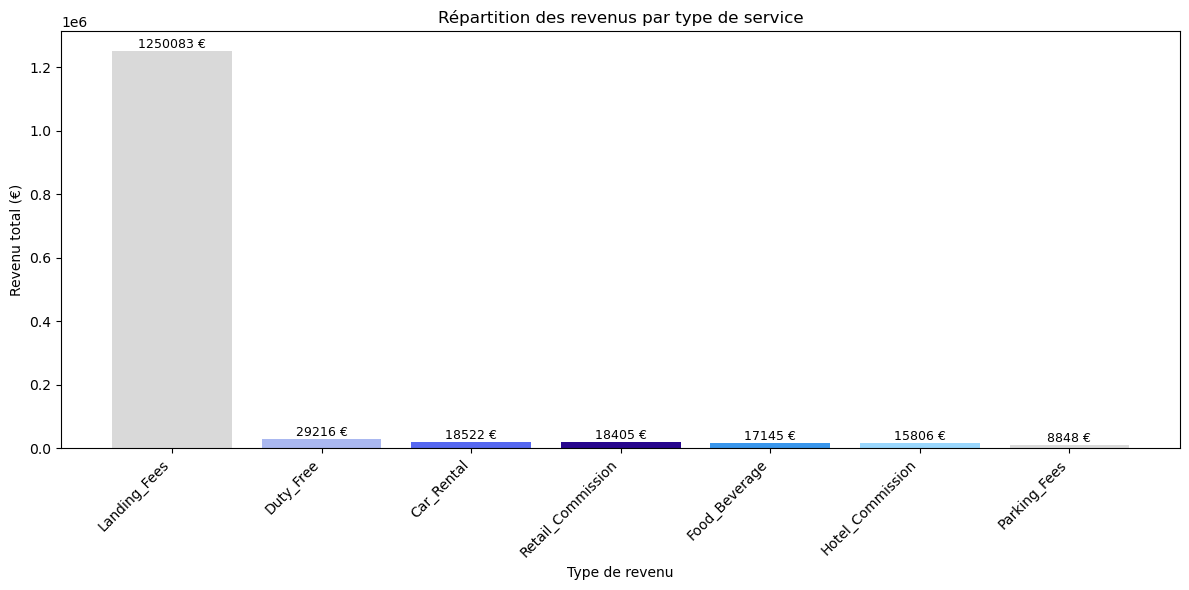

In [240]:
# ----------------------------------
# Graphique : Revenu total par type
# ----------------------------------

plt.figure(figsize=(12,6))

bars = plt.bar(
    revenus_type["Revenue_Stream"],
    revenus_type["revenus_total"],
    color=blue_palette)

# Ajout des labels sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)} €",
        ha="center",
        va="bottom",
        fontsize=9)

plt.xlabel("Type de revenu")
plt.ylabel("Revenu total (€)")
plt.title("Répartition des revenus par type de service")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Les revenus présentent des écarts significatifs entre terminaux, tant en valeur totale qu’en performance moyenne par transaction.

- Les terminaux 2C et 1 sont les plus performants, avec les revenus totaux les plus élevés et un revenu moyen supérieur autour de 1 000 €.
- Les terminaux 2F, 2B, 2D et 2E génèrent des revenus solides mais reposent davantage sur le volume que sur la valeur unitaire.

- 2A et 3 affichent les paniers moyens les plus faibles, limitant leur contribution globale.

En résumé, les écarts de revenus s’expliquent principalement par la valeur unitaire des transactions, et non par le volume. Les terminaux 2C et 1 concentrent les transactions à plus forte valeur, ce qui en fait des leviers prioritaires pour la stratégie de revenus.

Indicateur de Performance : Coût Estimé du Retard

Base de calcul : 250 € par minute.

Justification : Ce montant reflète la moyenne sectorielle combinant les pénalités de retard, les frais d'assistance aux passagers et les coûts opérationnels de rattrapage. Il sert à quantifier le manque à gagner réel généré par les inefficacités logistiques.

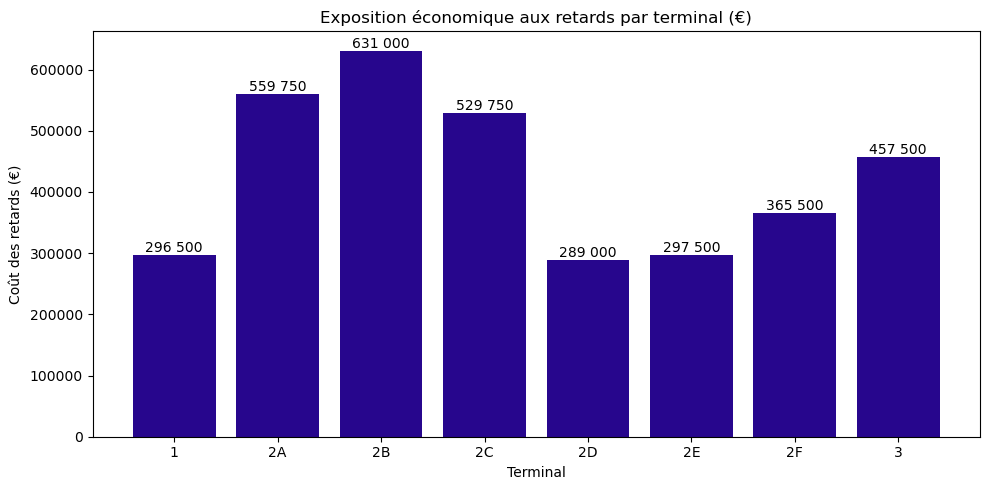

In [241]:
# -------------------------------
# Coûts des retards par terminal
# -------------------------------

cost_per_min = 250  # € par minute

# Création de la table
delay_cost_terminal = (df_vols_retardes.groupby("Terminal")
    .agg(total_delay_minutes=("Delay_Minutes", "sum"))
    .reset_index())

delay_cost_terminal["total_delay_cost"] = (delay_cost_terminal["total_delay_minutes"] * cost_per_min)

# ----------
# Graphique
# ----------

plt.figure(figsize=(10,5))

bars = plt.bar(
    delay_cost_terminal["Terminal"],
    delay_cost_terminal["total_delay_cost"],
    color=blue_palette[3])

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{int(h):,}".replace(",", " "),
        ha="center",
        va="bottom",
        fontsize=10)

plt.title("Exposition économique aux retards par terminal (€)")
plt.xlabel("Terminal")
plt.ylabel("Coût des retards (€)")
plt.grid(False)
plt.tight_layout()
plt.show()


L’analyse des coûts totaux de retard sur la semaine montre une forte disparité entre les terminaux. Le terminal 2B génère de loin le coût le plus élevé (≈631 k€), suivi des terminaux 2A et 2C, ce qui indique qu’ils constituent les principaux points de vulnérabilité en matière de retards.

À l’inverse, les terminaux 2D, 1 et 2E affichent les coûts les plus faibles (autour de 290–300 k€), suggérant une meilleure performance opérationnelle ou une moindre exposition aux perturbations.

Ainsi, les efforts de réduction des retards devraient être prioritairement concentrés sur les terminaux 2B, 2A et 2C, où le potentiel d’économies est le plus important.

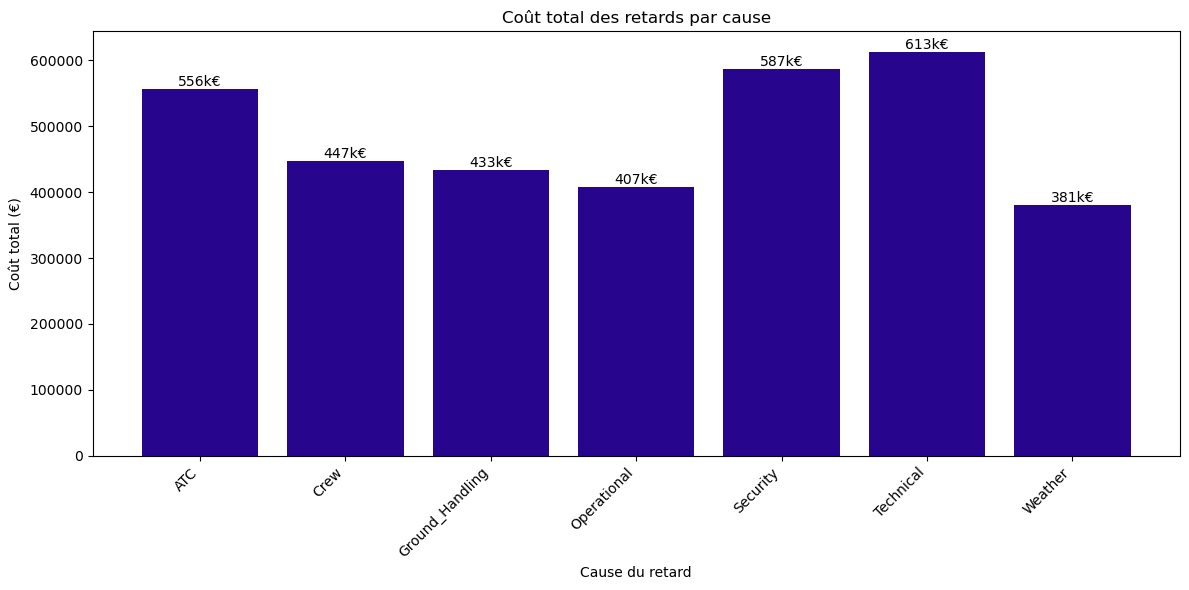

In [242]:
# ---------------------------
# Coût des retards par cause
# ---------------------------

# Création de la table
delay_cost_by_cause = (df_vols_retardes.groupby("Delay_Category")
    .agg(total_delay_minutes=("Delay_Minutes", "sum"))
    .reset_index()
)

delay_cost_by_cause["total_cost"] = (delay_cost_by_cause["total_delay_minutes"] * cost_per_min)

# Graphique
plt.figure(figsize=(12,6))

bars = plt.bar(
    delay_cost_by_cause["Delay_Category"],
    delay_cost_by_cause["total_cost"],
    color=blue_palette[3])

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{int(h/1000)}k€",
        ha="center",
        va="bottom",
        fontsize=10)

plt.title("Coût total des retards par cause")
plt.xlabel("Cause du retard")
plt.ylabel("Coût total (€)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Les coûts des retards sont dominés par des causes internes maîtrisables (Technical et Security), qui représentent à elles seules la plus forte charge financière. Cela indique que la principale source de perte ne provient pas d’aléas externes, mais de défaillances opérationnelles et organisationnelles.

L’ATC constitue un facteur intermédiaire : partiellement externe, il n’est pas totalement maîtrisable par l’aéroport, mais une meilleure coordination opérationnelle permet d’en limiter l’impact économique.

À l’inverse, la météo – pourtant souvent perçue comme critique – génère le coût le plus faible, confirmant qu’elle n’est pas le facteur principal de désorganisation économique.

Enjeu clé : la réduction des coûts passe prioritairement par l’optimisation des processus techniques, de la maintenance et de la sécurité, tout en renforçant la coordination avec l’ATC, où des gains significatifs restent possibles.

In [243]:
# ------------------------------------------
# Coûts de retard par terminal et par cause
# ------------------------------------------

cause_terminal_cost = (df_vols_retardes.groupby(["Terminal", "Delay_Category"])
    .agg(total_delay_minutes=("Delay_Minutes", "sum"))
    .reset_index())

cause_terminal_cost["cost"] = (cause_terminal_cost["total_delay_minutes"] * cost_per_min)


# -----------------------
# Affichage par terminal
# -----------------------

# Total coût par terminal
total_cost_terminal = (cause_terminal_cost.groupby("Terminal")["cost"].sum().reset_index(name="total_terminal_cost"))

# Fusion
detail_terminal = cause_terminal_cost.merge(total_cost_terminal,on="Terminal")

# Calcul %
detail_terminal["part_%"] = (
    detail_terminal["cost"] /
    detail_terminal["total_terminal_cost"] * 100
).round(1)

# Ordre logique des terminaux
ordre_terminaux = ["1","2A","2B","2C","2D","2E","2F","3"]

# Boucle
for terminal in ordre_terminaux:

    df_temp = detail_terminal[detail_terminal["Terminal"] == terminal].sort_values("cost", ascending=False)

    print("\n" + "="*55)
    print(f"TERMINAL {terminal}")
    print("="*55)

    if df_temp.empty:
        print("Aucune donnée disponible pour ce terminal")
    else:
        display(
            df_temp[["Delay_Category", "cost", "part_%"]])



TERMINAL 1


,Delay_Category,cost,part_%
1,Crew,69500,23.4
0,ATC,68500,23.1
5,Technical,49750,16.8
2,Ground_Handling,37500,12.6
6,Weather,31500,10.6
3,Operational,20250,6.8
4,Security,19500,6.6



TERMINAL 2A


,Delay_Category,cost,part_%
11,Security,188750,33.7
10,Operational,113750,20.3
8,Crew,85500,15.3
12,Technical,85000,15.2
13,Weather,66000,11.8
9,Ground_Handling,11000,2.0
7,ATC,9750,1.7



TERMINAL 2B


,Delay_Category,cost,part_%
16,Ground_Handling,130000,20.6
17,Operational,113000,17.9
19,Technical,106500,16.9
14,ATC,91750,14.5
20,Weather,76000,12.0
18,Security,71250,11.3
15,Crew,42500,6.7



TERMINAL 2C


,Delay_Category,cost,part_%
21,ATC,180500,34.1
26,Weather,118750,22.4
25,Technical,88000,16.6
22,Crew,61250,11.6
23,Operational,45250,8.5
24,Security,36000,6.8



TERMINAL 2D


,Delay_Category,cost,part_%
31,Security,70500,24.4
32,Technical,59750,20.7
28,Crew,46750,16.2
27,ATC,44250,15.3
30,Operational,33000,11.4
29,Ground_Handling,19750,6.8
33,Weather,15000,5.2



TERMINAL 2E


,Delay_Category,cost,part_%
37,Security,100750,33.9
35,Crew,76250,25.6
34,ATC,44250,14.9
38,Technical,44250,14.9
36,Ground_Handling,32000,10.8



TERMINAL 2F


,Delay_Category,cost,part_%
43,Technical,87000,23.8
39,ATC,79250,21.7
40,Ground_Handling,78750,21.5
44,Weather,49000,13.4
41,Operational,43000,11.8
42,Security,28500,7.8



TERMINAL 3


,Delay_Category,cost,part_%
47,Ground_Handling,124750,27.3
50,Technical,93000,20.3
49,Security,71750,15.7
46,Crew,65750,14.4
48,Operational,39500,8.6
45,ATC,38000,8.3
51,Weather,24750,5.4


Les coûts des retards sont massivement concentrés sur des causes internes maîtrisables :

Technical + Security + Ground Handling + Operational + Crew représentent plus de 65 % des pertes sur la majorité des terminaux.

Part des côuts de retards liés à des causes internes : 
- Terminal 1 : 66 %
- Terminal 2A : 87 %
- Terminal 2B : 73 %
- Terminal 2C : 44 % seulement (cas particulier : dépendance forte à ATC & météo)
- Terminal 2D : 80 %
- Terminal 2E : 85 %
- Terminal 2F : 65 %
- Terminal 3 : 86 %

Message clé :

- 7 terminaux sur 8 ont au moins 65 % de coûts liés à des causes internes.
- Le principal levier d’économie est interne, pas externe.
- Optimisation de la maintenance, de la sécurité, de l'organisation terrain = ROI immédiat.

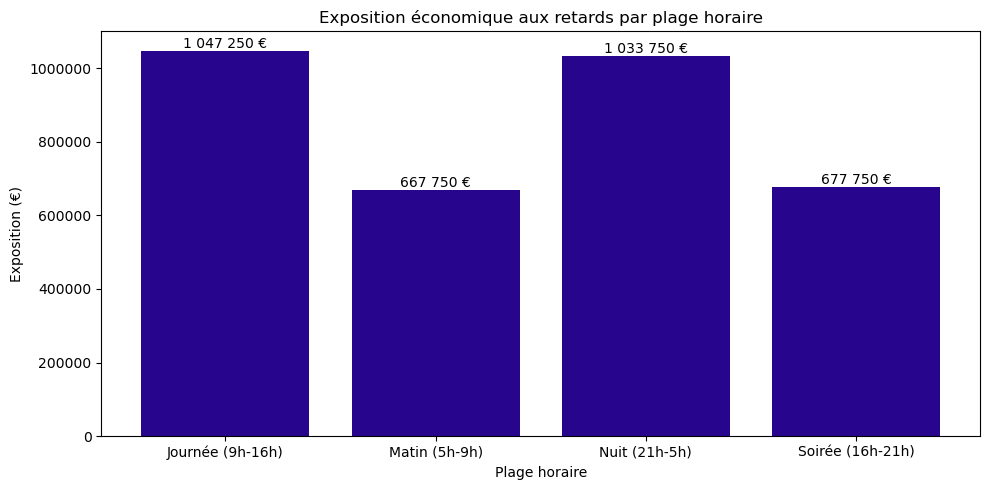

In [244]:
# ----------------------------------------
# Exposition économique par plage horaire
# ----------------------------------------

# Création de la table
exposure_plage = (df_vols_retardes.groupby("Plage_Horaire")
    .agg(total_delay_minutes=("Delay_Minutes", "sum"))
    .reset_index())

exposure_plage["exposure_total"] = exposure_plage["total_delay_minutes"] * cost_per_min

# Graphique
plt.figure(figsize=(10,5))

bars = plt.bar(
    exposure_plage["Plage_Horaire"],
    exposure_plage["exposure_total"],
    color=blue_palette[3]
)

# Valeurs sur les barres
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{int(h):,}".replace(",", " ") + " €",
        ha="center",
        va="bottom")

# Suppression notation scientifique (1e6)
plt.ticklabel_format(style='plain', axis='y')

plt.title("Exposition économique aux retards par plage horaire")
plt.xlabel("Plage horaire")
plt.ylabel("Exposition (€)")
plt.tight_layout()
plt.show()

Ce graphique montre combien coûtent les retards selon le moment de la journée.

Les retards qui surviennent en journée et la nuit coûtent beaucoup plus cher à l’aéroport.
Ce ne sont pas forcément les périodes avec le plus de vols, mais celles où les retards sont les plus pénalisants économiquement.

L’exposition économique aux retards est nettement plus élevée en journée (9h–16h) et la nuit (21h–5h), où les pertes dépassent 1 M€, ce qui en fait les périodes les plus critiques financièrement. 

À l’inverse, le matin et la soirée présentent un impact économique plus modéré, autour de 670 k€.

Cela montre que les efforts de prévention et de mobilisation des ressources doivent être prioritairement concentrés sur la journée et la nuit, périodes où les retards génèrent les pertes financières les plus importantes.

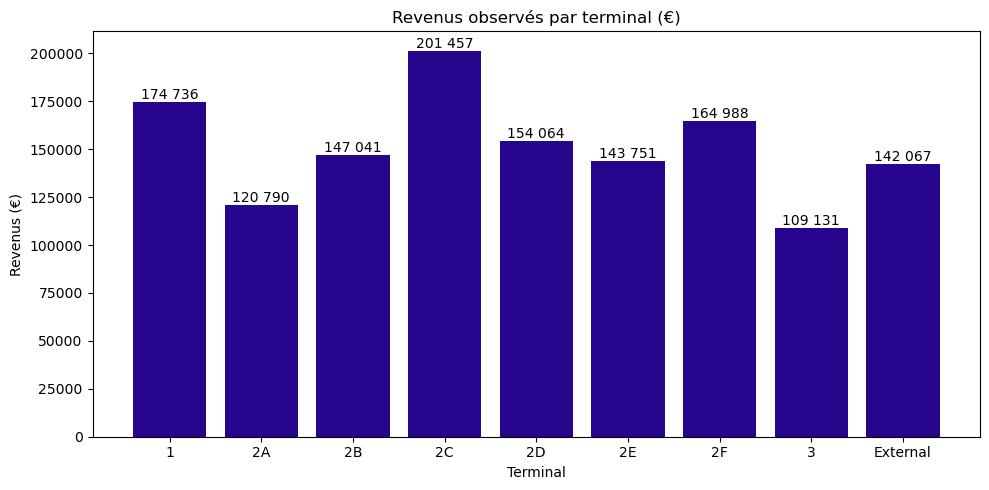

In [245]:
# ---------------------
# Revenus par terminal
# ---------------------

# Création revenus_terminal (manquant)
revenus_terminal = (
    df_finance_new
    .groupby("Terminal")
    .agg(revenus_total=("Amount_EUR", "sum"))
    .reset_index())

plt.figure(figsize=(10,5))

bars = plt.bar(
    revenus_terminal["Terminal"],
    revenus_terminal["revenus_total"],
    color=blue_palette[3])

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        h,
        f"{int(h):,}".replace(",", " "),
        ha="center",
        va="bottom")

plt.title("Revenus observés par terminal (€)")
plt.xlabel("Terminal")
plt.ylabel("Revenus (€)")
plt.tight_layout()
plt.show()


- Le terminal 2C est le principal contributeur aux revenus, confirmant son rôle stratégique dans la performance financière globale de l’aéroport. - Les terminaux 1 et 2F affichent également des niveaux de revenus élevés, traduisant une bonne attractivité commerciale.
- À l’inverse, les terminaux 3 et 2A génèrent les revenus les plus faibles, ce qui souligne un potentiel d’optimisation commerciale ou un positionnement moins premium.

Globalement, la dispersion des revenus entre terminaux montre que la création de valeur est concentrée sur quelques pôles clés.

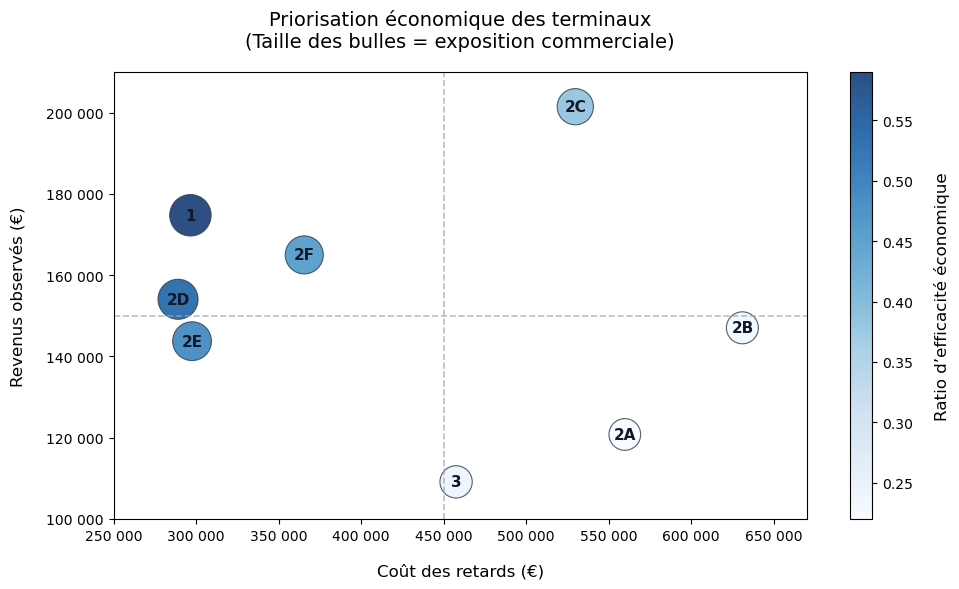

In [246]:
# -------------------------------------
# Performance économique des terminaux
# -------------------------------------

# Indicateurs économiques par terminal
economic_data = (delay_cost_terminal.merge(
        revenus_terminal,
        on="Terminal",
        how="left"
    ))

economic_data["ratio"] = (economic_data["revenus_total"] / economic_data["total_delay_cost"])

terminals = {}

for _, row in economic_data.iterrows():
    terminals[row["Terminal"]] = {
        "cost": row["total_delay_cost"],
        "revenue": row["revenus_total"],
        "ratio": round(row["ratio"], 2)}


# Données (inchangées)
costs = [data['cost'] for data in terminals.values()]
revenues = [data['revenue'] for data in terminals.values()]
ratios = [data['ratio'] for data in terminals.values()]
labels = list(terminals.keys())

sizes = [300 + ratio * 1000 for ratio in ratios]


# Graphique
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    costs,
    revenues,
    s=sizes,
    c=ratios,
    cmap="Blues",
    alpha=0.85,
    edgecolors='#374151',
    linewidth=0.8)

# Labels bulles
for i, label in enumerate(labels):
    ax.annotate(
        label,
        (costs[i], revenues[i]),
        ha='center',
        va='center',
        fontsize=11,
        fontweight='bold',
        color='#111827'
    )

# Médianes
median_cost = 450000
median_revenue = 150000

ax.axvline(
    x=median_cost,
    color='#9ca3af',
    linestyle='--',
    linewidth=1.2,
    alpha=0.7)

ax.axhline(
    y=median_revenue,
    color='#9ca3af',
    linestyle='--',
    linewidth=1.2,
    alpha=0.7)

# Axes (espacés)
ax.set_xlabel(
    'Coût des retards (€)',
    fontsize=12,
    labelpad=15)

ax.set_ylabel(
    'Revenus observés (€)',
    fontsize=12,
    labelpad=15
)

ax.set_title(
    'Priorisation économique des terminaux\n'
    '(Taille des bulles = exposition commerciale)',
    fontsize=14,
    pad=18)

# Format €
ax.xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', ' ')))

ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, p: f'{int(y):,}'.replace(',', ' ')))

# Pas de grille
ax.grid(False)

# Codage couleur du ratio
cbar = plt.colorbar(scatter, ax=ax, pad=0.05)

cbar.set_label(
    "Ratio d’efficacité économique",
    fontsize=12,
    labelpad=15)

# Limites
ax.set_xlim(250000, 670000)
ax.set_ylim(100000, 210000)

plt.tight_layout()
plt.show()

Le graphique révèle un déséquilibre marqué entre revenus générés et coûts de retard selon les terminaux.

Terminal 1 – Le plus efficient, avec un bon équilibre revenus/coûts. Les retards sont surtout dus à Crew et ATC, donc à des facteurs externes. L’enjeu est d’améliorer la coordination avec les compagnies et le contrôle aérien.

Terminal 2A – Profil fragile (coûts élevés et revenus faibles). Les causes dominantes sont Security et Operational, ce qui traduit des dysfonctionnements internes. Il faudrait mettre en place des mesures d’optimisation des contrôles sûreté et des processus opérationnels plus efficaces.

Terminal 2B – Terminal le plus exposé économiquement. Les causes des retards sont très réparties : 55,4% sont dûs au Ground Handling, Operational, et Technical, révélant un problème systémique. Un audit global de la chaîne opérationnelle est nécessaire.

Terminal 2C – Plus gros générateur de revenus mais fortement pénalisé par les coûts de retard. Les causes principales causes de retards sont externes (ATC et Weather à 56,5%). L’enjeu est l’anticipation météo et la mobilisation des équipes pour faire face aux aléas climatiques (ex : déploiement anticipé des équipes piste, préparation des engins, briefing du staff en amont).
Des leviers internes concrets peuvent être mis en place sur Technical et Crew (adaptation des plannings, renforcement de la maintenance préventive).

Terminal 2D – Performance intermédiaire. Les retards sont surtout liés à Security et Technical, laissant des leviers internes d’amélioration. Actions recommandées : modernisation des équipements et optimisation des contrôles.

Terminal 2E – Performance intermédiaire, marquée par une prédominance des retards liés à la sécurité et aux équipages, révélant des contraintes organisationnelles. Les principaux leviers d'amélioration résident dans l’adaptation des plannings aux pics de trafic, l’optimisation des contrôles à l’immigration et le renforcement ciblé des effectifs, en cohérence avec le rôle du terminal, majoritairement dédié aux vols long-courriers internationaux.

Terminal 2F – Assez bonne performance commerciale mais instabilité opérationnelle. Les retards sont principalement liés aux catégories Technical (23,8 %), ATC (21,7 %) et Ground Handling (21,5 %). Cela montre que les dysfonctionnements proviennent à la fois de contraintes techniques, du contrôle aérien et des opérations au sol.
Leviers opérationnels : renforcer la présence des équipes maintenance sur les plages horaires critiques et améliorer la coordination terrain entre handling et exploitation.

Terminal 3 – Faible contribution aux revenus avec des coûts élevés. Les causes de retards sont majoritairement internes (86,3% des retards). Cela révèle une une fragilité structurelle. Une profonde restructuration organisationnelle est nécéssaire.

In [247]:
# --------------------------
# Impact attente vs revenus
# --------------------------

# Agrégation flux passagers (par jour)
df_flux_daily = (df_passenger_new.groupby(['Terminal', 'Date'])
    .agg(
        Wait_Time_Minutes=('Wait_Time_Minutes', 'mean'),
        Queue_Length=('Queue_Length', 'mean')
    ).reset_index())

# Agrégation finance (par jour)
df_finance_daily = (df_finance_new.groupby(['Terminal', 'Date'])
    .agg(
        Amount_EUR=('Amount_EUR', 'sum'),
        nb_transactions=('Transaction_ID', 'count')
    ).reset_index()
)

# Fusion
df_impact = df_flux_daily.merge(df_finance_daily,on=['Terminal', 'Date'], how='inner')

# Corrélation
correlation = df_impact['Wait_Time_Minutes'].corr(
    df_impact['Amount_EUR']
)

print(f"Corrélation Attente / Revenus : {correlation:.2f}")

Corrélation Attente / Revenus : -0.02


L’analyse montre une corrélation quasi nulle (-0,02) entre le temps d’attente et les revenus.

Cela indique que la réduction des files d’attente améliore l’expérience passager, mais n’a pas d’impact direct mesurable sur le chiffre d’affaires à court terme.